In [1]:
import time
timestamp = time.time()
print(timestamp)
sample_interval = 0.1
rounded_timestamp = round(timestamp / sample_interval) * sample_interval
print(rounded_timestamp)

1732655489.592521
1732655489.6000001


In [2]:
next_time = time.time()
print(next_time)
next_time = next_time - (next_time % sample_interval)
print(next_time)

1732655490.7213643
1732655490.7


In [3]:
import datetime
timestamp_str = datetime.datetime.fromtimestamp(timestamp).strftime('%H:%M:%S.%f')
print(timestamp_str)

21:11:29.592521


In [4]:
import os
import time
import threading
import subprocess
import pynvml
from datetime import datetime
from threading import Thread, Event
import argparse
import socket
import struct
import json

In [5]:
import threading
import time
import random

def thread_function(name, barrier, measurements,sample_interval=0.1):
    while not stop_event.is_set():
        # Wait until all threads have reached this point
        barrier.wait()
        # Take the measurement
        measurement = take_measurement(name)
        timestamp = time.time()
        next_time= timestamp + sample_interval
        rounded_timestamp = round((timestamp / sample_interval) * sample_interval, 1)
        measurements.append((rounded_timestamp, measurement))
        # Sleep to simulate work and control the measurement interval
        sleep_time = next_time - time.time()
        if sleep_time > 0:
            time.sleep(sleep_time)
        else:
            pass

def take_measurement(thread_name):
    # Replace this with actual measurement code
    return f"Measurement from {thread_name} {round(random.random(),1)}"

# Parameters
measurement_interval = 0.1  # Time between measurements in seconds
total_runtime = 1  # Total time to run the measurement in seconds

# Synchronization primitives
num_threads = 2
barrier = threading.Barrier(num_threads)
stop_event = threading.Event()

# Data storage
measurements_a = []
measurements_b = []

# Create and start threads
thread_a = threading.Thread(target=thread_function, args=("Thread A", barrier, measurements_a))
thread_b = threading.Thread(target=thread_function, args=("Thread B", barrier, measurements_b))
thread_a.start()
thread_b.start()

# Let the threads run for the specified total runtime
time.sleep(total_runtime)
stop_event.set()

# Wait for threads to finish
thread_a.join()
thread_b.join()

# Print measurements
print("Measurements from Thread A:")
for timestamp, measurement in measurements_a:
    print(f"Time: {timestamp}, Measurement: {measurement}")

print("\nMeasurements from Thread B:")
for timestamp, measurement in measurements_b:
    print(f"Time: {timestamp}, Measurement: {measurement}")


Measurements from Thread A:
Time: 1732655500.4, Measurement: Measurement from Thread A 0.8
Time: 1732655500.5, Measurement: Measurement from Thread A 0.3
Time: 1732655500.6, Measurement: Measurement from Thread A 0.9
Time: 1732655500.7, Measurement: Measurement from Thread A 1.0
Time: 1732655500.8, Measurement: Measurement from Thread A 0.7
Time: 1732655500.9, Measurement: Measurement from Thread A 0.5
Time: 1732655501.0, Measurement: Measurement from Thread A 1.0
Time: 1732655501.1, Measurement: Measurement from Thread A 0.8
Time: 1732655501.2, Measurement: Measurement from Thread A 0.7
Time: 1732655501.3, Measurement: Measurement from Thread A 0.1

Measurements from Thread B:
Time: 1732655500.4, Measurement: Measurement from Thread B 0.3
Time: 1732655500.5, Measurement: Measurement from Thread B 0.0
Time: 1732655500.6, Measurement: Measurement from Thread B 0.7
Time: 1732655500.7, Measurement: Measurement from Thread B 0.5
Time: 1732655500.8, Measurement: Measurement from Thread B 0.

In [6]:
import threading
import time
import random
from queue import Queue, Empty

def thread_function(name, barrier, measurements_queue, sample_interval=0.1):
    while not stop_event.is_set():
        # Wait until all threads have reached this point
        barrier.wait()
        timestamp = time.time()
        # Round the timestamp to align to sample_interval
        rounded_timestamp = round((timestamp / sample_interval) * sample_interval, 1)
        # Take the measurement
        measurement = take_measurement(name)
        measurements_queue.put((rounded_timestamp, measurement))
        # Sleep to control the measurement interval
        next_time = timestamp + sample_interval
        sleep_time = next_time - time.time()
        if sleep_time > 0:
            time.sleep(sleep_time)
        else:
            pass

def take_measurement(thread_name):
    # Replace this with actual measurement code
    return f"Measurement from {thread_name} {round(random.random(),1)}"

def accumulator_function(measurements_a, measurements_b, sample_interval):
    data_a = {}
    data_b = {}
    processed_timestamps = set()
    last_measurement_a = None
    last_measurement_b = None

    while not stop_event.is_set() or not measurements_a.empty() or not measurements_b.empty():
        # Try to get new measurements from the queues
        try:
            while True:
                timestamp_a, measurement_a = measurements_a.get_nowait()
                data_a[timestamp_a] = measurement_a
        except Empty:
            pass

        try:
            while True:
                timestamp_b, measurement_b = measurements_b.get_nowait()
                data_b[timestamp_b] = measurement_b
        except Empty:
            pass

        # Get all timestamps that have measurements from at least one thread
        all_timestamps = set(data_a.keys()) | set(data_b.keys())
        pending_timestamps = sorted(all_timestamps - processed_timestamps)

        for timestamp in pending_timestamps:
            measurement_a = data_a.get(timestamp)
            measurement_b = data_b.get(timestamp)

            # If we have measurements from both threads, process them
            if measurement_a is not None and measurement_b is not None:
                print(f"Time: {timestamp}, Measurement A: {measurement_a}, Measurement B: {measurement_b}")
                last_measurement_a = measurement_a
                last_measurement_b = measurement_b
                processed_timestamps.add(timestamp)
                del data_a[timestamp]
                del data_b[timestamp]
            else:
                # If we don't have both measurements, check if we should fill in missing data
                time_since_timestamp = time.time() - timestamp
                if time_since_timestamp > sample_interval * 2:
                    # Fill in missing measurements using last known values
                    if measurement_a is None:
                        measurement_a = last_measurement_a
                    else:
                        last_measurement_a = measurement_a
                    if measurement_b is None:
                        measurement_b = last_measurement_b
                    else:
                        last_measurement_b = measurement_b

                    print(f"Time: {timestamp}, Measurement A: {measurement_a}, Measurement B: {measurement_b} (Filled)")
                    processed_timestamps.add(timestamp)
                    if timestamp in data_a:
                        del data_a[timestamp]
                    if timestamp in data_b:
                        del data_b[timestamp]

        time.sleep(0.01)

# Parameters
measurement_interval = 0.1  # Time between measurements in seconds
total_runtime = 1  # Total time to run the measurement in seconds

# Synchronization primitives
num_threads = 2
barrier = threading.Barrier(num_threads)
stop_event = threading.Event()

# Data storage
measurements_a = Queue()
measurements_b = Queue()

# Create and start threads
thread_a = threading.Thread(target=thread_function, args=("Thread A", barrier, measurements_a, measurement_interval))
thread_b = threading.Thread(target=thread_function, args=("Thread B", barrier, measurements_b, measurement_interval))
accumulator_thread = threading.Thread(target=accumulator_function, args=(measurements_a, measurements_b, measurement_interval))

thread_a.start()
thread_b.start()
accumulator_thread.start()

# Let the threads run for the specified total runtime
time.sleep(total_runtime)
stop_event.set()

# Wait for threads to finish
thread_a.join()
thread_b.join()
accumulator_thread.join()


Time: 1732655508.1, Measurement A: Measurement from Thread A 0.7, Measurement B: Measurement from Thread B 0.1
Time: 1732655508.2, Measurement A: Measurement from Thread A 0.9, Measurement B: Measurement from Thread B 0.4
Time: 1732655508.3, Measurement A: Measurement from Thread A 0.9, Measurement B: Measurement from Thread B 1.0
Time: 1732655508.4, Measurement A: Measurement from Thread A 0.8, Measurement B: Measurement from Thread B 0.3
Time: 1732655508.5, Measurement A: Measurement from Thread A 0.4, Measurement B: Measurement from Thread B 0.7
Time: 1732655508.6, Measurement A: Measurement from Thread A 0.2, Measurement B: Measurement from Thread B 0.4
Time: 1732655508.7, Measurement A: Measurement from Thread A 0.8, Measurement B: Measurement from Thread B 0.4
Time: 1732655508.8, Measurement A: Measurement from Thread A 0.5, Measurement B: Measurement from Thread B 0.9
Time: 1732655508.9, Measurement A: Measurement from Thread A 0.5, Measurement B: Measurement from Thread B 0.9
T

In [7]:
batch =[(1732332507.4, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.92}, 'gpu': {'gpu_energy': 1.68}}), (1732332507.3, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.99}, 'gpu': {'gpu_energy': 1.82}}), (1732332507.6, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.92}, 'gpu': {'gpu_energy': 1.68}}), (1732332507.7, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.97}, 'gpu': {'gpu_energy': 1.68}}), (1732332507.8, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.93}, 'gpu': {'gpu_energy': 1.87}}), (1732332508.0, {'cpu_memory': {'memory_energy': 1.47, 'cpu_energy': 9.59}, 'gpu': {'gpu_energy': 1.87}}), (1732332508.1, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.94}, 'gpu': {'gpu_energy': 1.87}}), (1732332508.2, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.93}, 'gpu': {'gpu_energy': 1.87}}), (1732332508.4, {'cpu_memory': {'memory_energy': 1.38, 'cpu_energy': 9.0}, 'gpu': {'gpu_energy': 1.87}}), (1732332508.5, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.93}, 'gpu': {'gpu_energy': 1.87}}), (1732332508.7, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.97}, 'gpu': {'gpu_energy': 1.87}}), (1732332508.8, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.94}, 'gpu': {'gpu_energy': 1.87}}), (1732332508.9, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.92}, 'gpu': {'gpu_energy': 1.74}}), (1732332509.1, {'cpu_memory': {'memory_energy': 1.35, 'cpu_energy': 8.93}, 'gpu': {'gpu_energy': 1.74}}), (1732332509.2, {'cpu_memory': {'memory_energy': 1.35, 'cpu_energy': 8.97}, 'gpu': {'gpu_energy': 1.74}}), (1732332509.3, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.98}, 'gpu': {'gpu_energy': 1.78}}), (1732332509.5, {'cpu_memory': {'memory_energy': 1.34, 'cpu_energy': 8.93}, 'gpu': {'gpu_energy': 1.78}}), (1732332509.6, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.96}, 'gpu': {'gpu_energy': 1.78}}), (1732332509.8, {'cpu_memory': {'memory_energy': 1.38, 'cpu_energy': 8.97}, 'gpu': {'gpu_energy': 1.78}}), (1732332509.9, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.93}, 'gpu': {'gpu_energy': 1.78}})]

In [8]:
for i in batch:
    print(i)

(1732332507.4, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.92}, 'gpu': {'gpu_energy': 1.68}})
(1732332507.3, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.99}, 'gpu': {'gpu_energy': 1.82}})
(1732332507.6, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.92}, 'gpu': {'gpu_energy': 1.68}})
(1732332507.7, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.97}, 'gpu': {'gpu_energy': 1.68}})
(1732332507.8, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.93}, 'gpu': {'gpu_energy': 1.87}})
(1732332508.0, {'cpu_memory': {'memory_energy': 1.47, 'cpu_energy': 9.59}, 'gpu': {'gpu_energy': 1.87}})
(1732332508.1, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.94}, 'gpu': {'gpu_energy': 1.87}})
(1732332508.2, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.93}, 'gpu': {'gpu_energy': 1.87}})
(1732332508.4, {'cpu_memory': {'memory_energy': 1.38, 'cpu_energy': 9.0}, 'gpu': {'gpu_energy': 1.87}})
(1732332508.5, {'cpu_memory': {'memory_energy': 1.37, 'c

In [9]:
batch.sort(key=lambda x: x[0])
for i in batch:
    print(i)
timestamps = [entry[0] for entry in batch]
missed_timestamps=[]
for i in range(len(timestamps) - 1):
    if timestamps[i + 1] * 10 - timestamps[i] * 10 == 2:
        missed_timestamps.append((timestamps[i] * 10 + 1)/10)
        # print((timestamps[i] * 10 + 1)/10)
print(missed_timestamps)

(1732332507.3, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.99}, 'gpu': {'gpu_energy': 1.82}})
(1732332507.4, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.92}, 'gpu': {'gpu_energy': 1.68}})
(1732332507.6, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.92}, 'gpu': {'gpu_energy': 1.68}})
(1732332507.7, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.97}, 'gpu': {'gpu_energy': 1.68}})
(1732332507.8, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.93}, 'gpu': {'gpu_energy': 1.87}})
(1732332508.0, {'cpu_memory': {'memory_energy': 1.47, 'cpu_energy': 9.59}, 'gpu': {'gpu_energy': 1.87}})
(1732332508.1, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.94}, 'gpu': {'gpu_energy': 1.87}})
(1732332508.2, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.93}, 'gpu': {'gpu_energy': 1.87}})
(1732332508.4, {'cpu_memory': {'memory_energy': 1.38, 'cpu_energy': 9.0}, 'gpu': {'gpu_energy': 1.87}})
(1732332508.5, {'cpu_memory': {'memory_energy': 1.37, 'c

In [ ]:
def fill_missing_timestamps(list_of_tuples, missing_timestamps):
    """
    Fills the missing timestamps in the list of tuples with measurements copied
    from the nearest timestamp.
    """
    # Sort the original list by timestamps
    list_of_tuples.sort(key=lambda x: x[0])
    
    # Combine original timestamps and measurements into a dictionary for easy access
    timestamp_to_measurement = {timestamp: measurement for timestamp, measurement in list_of_tuples}

    # Process each missing timestamp
    for missing in sorted(missing_timestamps):
        # Find the closest timestamp in the existing list
        closest_timestamp = min(timestamp_to_measurement.keys(), key=lambda t: abs(t - missing))
        # Copy the measurement of the closest timestamp to the missing timestamp
        timestamp_to_measurement[missing] = timestamp_to_measurement[closest_timestamp]

    # Create the new list of tuples, sorted by timestamps
    filled_list = sorted(timestamp_to_measurement.items(), key=lambda x: x[0])
    return filled_list

f_batch=fill_missing_timestamps(batch,missed_timestamps)
for i in f_batch:
    print(i)

In [ ]:
consolidated_data = [
            {
                'node_id': 'compute2',
                'timestamp': timestamp,
                'measurement': measurement
            }
            for timestamp, measurement in f_batch
        ]
print(consolidated_data, len(consolidated_data))

In [46]:
import subprocess
import re
import sys
import threading
from concurrent.futures import ThreadPoolExecutor, as_completed
import math
def parse_log_file(log_file):
    """
    Parses the log file to extract start and end times for data loading and computation phases.
    Returns a list of tuples: [(phase_name, start_time, end_time), ...]
    """
    time_pairs = []
    # phase_pattern = re.compile(
    #     r'(?P<phase>\w+ Phase): Start Time = (?P<start_time>[0-9.]+), End Time = (?P<end_time>[0-9.]+), Duration = [^\n]+'
    # )
    phase_pattern = re.compile(
    r'(?P<phase>[\w\s]+ [Pp]hase): Start Time = (?P<start_time>[0-9.]+), End Time = (?P<end_time>[0-9.]+), Duration = [^\n]+',
    re.IGNORECASE
    )
    with open(log_file, 'r') as f:
        for line in f:
            match = phase_pattern.search(line)
            if match:
                phase_name = match.group('phase')
                start_time = float(match.group('start_time'))
                end_time = float(match.group('end_time'))
                time_pairs.append((phase_name, start_time, end_time))
    return time_pairs

def read_inventory_file(inventory_file):
    """
    Reads the inventory file to get the list of IP addresses.
    """
    with open(inventory_file, 'r') as f:
        ips = [line.strip() for line in f if line.strip()]
    return ips

def run_query_on_node(ip, ssh_user, ssh_key, start_time, end_time):
    """
    SSH into the node, activate the pyenv environment, and run the query_database.py script.
    Returns the output from the script.
    """
    ssh_command = [
        'ssh',
        '-o', 'StrictHostKeyChecking=no',
        f'{ssh_user}@{ip}',
    ]
    if ssh_key:
        ssh_command.extend(['-i', ssh_key])

    # Construct the remote command with pyenv activation
    # Assuming pyenv is initialized in ~/.bashrc
    remote_command = (
        f'python3 /home/cc/MultiNodeEnergyTracker/query_database.py --start {start_time} --end {end_time}'
    )
    full_command = ssh_command + [remote_command]
    # print(full_command)

    try:
        result = subprocess.run(full_command, capture_output=True, text=True, timeout=120)
        if result.returncode != 0:
            print(f"Error executing command on {ip}: {result.stderr}", file=sys.stderr)
            return None
        return result.stdout.strip()
    except subprocess.TimeoutExpired:
        print(f"Timeout occurred while querying {ip}.", file=sys.stderr)
        return None
    except Exception as e:
        print(f"Exception occurred while querying {ip}: {e}", file=sys.stderr)
        return None


def parse_query_output(output):
    """
    Parses the output from query_database.py.
    Returns a dictionary with the parsed values.
    Example output:
    compute2: Number of entries: 158, CPU Energy: 1511.24, Memory Energy: 227.95, GPU Energy: 972.18
    """
    pattern = re.compile(
        r'(?P<node>\w+): Number of entries: (?P<entries>\d+), CPU Energy: (?P<cpu_energy>[0-9.]+), '
        r'Memory Energy: (?P<memory_energy>[0-9.]+), GPU Energy: (?P<gpu_energy>[0-9.]+)'
    )
    match = pattern.search(output)
    if match:
        return {
            'node': match.group('node'),
            'entries': int(match.group('entries')),
            'cpu_energy': float(match.group('cpu_energy')),
            'memory_energy': float(match.group('memory_energy')),
            'gpu_energy': float(match.group('gpu_energy')),
        }
    else:
        print(f"Failed to parse output: {output}", file=sys.stderr)
        return None

def adjust_energy_values(parsed_output, start_time, end_time):
    """
    Adjusts the energy values based on the expected number of entries.
    """
    actual_entries = parsed_output['entries']
    duration = end_time - start_time
    expected_entries = duration / 0.1  # 0.1s resolution
    if actual_entries == 0:
        print(f"No entries for node {parsed_output['node']} between {start_time} and {end_time}", file=sys.stderr)
        return None

    adjustment_factor = expected_entries / actual_entries

    adjusted_cpu_energy = parsed_output['cpu_energy'] * adjustment_factor
    adjusted_memory_energy = parsed_output['memory_energy'] * adjustment_factor
    adjusted_gpu_energy = parsed_output['gpu_energy'] * adjustment_factor

    return {
        'node': parsed_output['node'],
        'adjusted_cpu_energy': adjusted_cpu_energy,
        'adjusted_memory_energy': adjusted_memory_energy,
        'adjusted_gpu_energy': adjusted_gpu_energy,
    }

In [ ]:
time_pairs = parse_log_file("/home/cc/imagenetTrainingWithResnet/results/b32_w0_lfb.txt")
# print(time_pairs)
ips = read_inventory_file("inventory.txt")
print(ips)
    # Iterate over each time pair
final_results = {}

base_energies={"compute1":{"memory":13.5,"cpu":85.2,"gpu":18},"compute2":{"memory":13.4,"cpu":88.2,"gpu":15},"storage1":{"memory":15.8,"cpu":187.2,"gpu":0},"storage2":{"memory":7.4,"cpu":87.2,"gpu":0},"storage3":{"memory":8.3,"cpu":82.5,"gpu":0}}

for phase_name, start_time, end_time in time_pairs:
    print(f"\nProcessing phase '{phase_name}' from {start_time} to {end_time}")
    expected_entries = math.ceil((end_time - start_time) / 0.1)
    duration = round(end_time - start_time,2)
    print(f"Expected entries: {expected_entries:.2f}")
    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_ip = {
            executor.submit(run_query_on_node, ip, "cc", "~/.ssh/id_rsa", start_time, end_time): ip
            for ip in ips
        }
        for future in as_completed(future_to_ip):
            ip = future_to_ip[future]
            try:
                output = future.result()
                # print(output)
                if output is None:
                    continue
                parsed_output = parse_query_output(output)
                # print(parsed_output)
                if parsed_output is None:
                    continue
                adjusted_values = adjust_energy_values(parsed_output, start_time, end_time)
                # print(adjusted_values)
                if adjusted_values is None:
                    continue
    
                node = adjusted_values['node']
                if node not in final_results:
                    final_results[node] = {}
    
                # Store the adjusted energy values under the phase name
                final_results[node][phase_name] = {
                    'adjusted_cpu_energy': adjusted_values['adjusted_cpu_energy'],
                    'adjusted_memory_energy': adjusted_values['adjusted_memory_energy'],
                    'adjusted_gpu_energy': adjusted_values['adjusted_gpu_energy'],
                    'Duration': duration
                }
    
                print(f"Node {node}: Adjusted CPU Energy: {adjusted_values['adjusted_cpu_energy']:.2f}, "
                      f"Memory Energy: {adjusted_values['adjusted_memory_energy']:.2f}, "
                      f"GPU Energy: {adjusted_values['adjusted_gpu_energy']:.2f}, "
                      f"Duartion : {duration}")
                
    
            except Exception as e:
                print(f"Error processing node {ip}: {e}", file=sys.stderr)

    # Print the final dictionary
    print(f"\nFinal Results: {final_results}")
    # for node, phases in final_results.items():
    #     print(f"Node: {node}")
    #     for phase, energies in phases.items():
    #         # print(energies)
    #         print(f"  Phase: {phase}")
    #         print(f"    Adjusted CPU Energy: {energies['adjusted_cpu_energy']:.2f}")
    #         print(f"    Adjusted Memory Energy: {energies['adjusted_memory_energy']:.2f}")
    #         print(f"    Adjusted GPU Energy: {energies['adjusted_gpu_energy']:.2f}")
    #         print(f"    Duration:{energies['Duration']}")


In [ ]:
print(base_energies)

In [ ]:
print(final_results)

In [ ]:
import pandas as pd
def extract_name(file_path):
    basename = os.path.basename(file_path)
    name, _ = os.path.splitext(basename)
    parts = name.split('_')
    if len(parts) >= 2:
        first_part = parts[0]
        second_part = parts[1].capitalize()  # Capitalize the second part (e.g., "w0" -> "W0")
        result = first_part + second_part
        return result
    else:
        return None

name_directory="/home/cc/imagenetTrainingWithResnet/results/b32_w0_lfb.txt"
df={}
df['name']= extract_name(name_directory)
for node, phases in final_results.items():
    for phase, energies in phases.items():
        if phase == "Data Loading Phase":
            identifier = "DL"
        elif phase == "ForwardBackward Pass phase":
            identifier = "FBP"
        full_identifier=f"{node}_{identifier}"
        column_name= f"{full_identifier}_cpu"
        df[column_name]=energies['adjusted_cpu_energy']
        column_name= f"{full_identifier}_cpu_base"
        df[column_name]=base_energies[node]['cpu']*energies['Duration']
        column_name= f"{full_identifier}_memory"
        df[column_name]=energies['adjusted_memory_energy']
        column_name= f"{full_identifier}_memory_base"
        df[column_name]=base_energies[node]['memory']*energies['Duration']
        column_name= f"{full_identifier}_gpu"
        df[column_name]=energies['adjusted_gpu_energy']
        column_name= f"{full_identifier}_gpu_base"
        df[column_name]=base_energies[node]['gpu']*energies['Duration']
    

In [ ]:
dataFrame= pd.DataFrame([df])

In [ ]:
dataFrame

In [ ]:
dataFrame.describe()

In [47]:
import subprocess
import re
import sys
import threading
from concurrent.futures import ThreadPoolExecutor, as_completed
import math
import pandas as pd

def parse_log_file(log_file):
    time_pairs = []
    phase_pattern = re.compile(
    r'(?P<phase>[\w\s]+ [Pp]hase): Start Time = (?P<start_time>[0-9.]+), End Time = (?P<end_time>[0-9.]+), Duration = [^\n]+',
    re.IGNORECASE
    )
    with open(log_file, 'r') as f:
        for line in f:
            match = phase_pattern.search(line)
            if match:
                phase_name = match.group('phase')
                start_time = float(match.group('start_time'))
                end_time = float(match.group('end_time'))
                time_pairs.append((phase_name, start_time, end_time))
    return time_pairs

def read_inventory_file(inventory_file):
    with open(inventory_file, 'r') as f:
        ips = [line.strip() for line in f if line.strip()]
    return ips

def run_query_on_node(ip, ssh_user, ssh_key, start_time, end_time):
    ssh_command = [
        'ssh',
        '-o', 'StrictHostKeyChecking=no',
        f'{ssh_user}@{ip}',
    ]
    if ssh_key:
        ssh_command.extend(['-i', ssh_key])
    remote_command = (
        f'python3 /home/cc/MultiNodeEnergyTracker/query_database.py --start {start_time} --end {end_time}'
    )
    full_command = ssh_command + [remote_command]
    try:
        result = subprocess.run(full_command, capture_output=True, text=True, timeout=120)
        if result.returncode != 0:
            print(f"Error executing command on {ip}: {result.stderr}", file=sys.stderr)
            return None
        return result.stdout.strip()
    except subprocess.TimeoutExpired:
        print(f"Timeout occurred while querying {ip}.", file=sys.stderr)
        return None
    except Exception as e:
        print(f"Exception occurred while querying {ip}: {e}", file=sys.stderr)
        return None


def parse_query_output(output):
    pattern = re.compile(
        r'(?P<node>\w+): Number of entries: (?P<entries>\d+), CPU Energy: (?P<cpu_energy>[0-9.]+), '
        r'Memory Energy: (?P<memory_energy>[0-9.]+), GPU Energy: (?P<gpu_energy>[0-9.]+)'
    )
    match = pattern.search(output)
    if match:
        return {
            'node': match.group('node'),
            'entries': int(match.group('entries')),
            'cpu_energy': float(match.group('cpu_energy')),
            'memory_energy': float(match.group('memory_energy')),
            'gpu_energy': float(match.group('gpu_energy')),
        }
    else:
        print(f"Failed to parse output: {output}", file=sys.stderr)
        return None

def adjust_energy_values(parsed_output, start_time, end_time):
    actual_entries = parsed_output['entries']
    duration = end_time - start_time
    expected_entries = math.ceil(duration / 0.1)  # 0.1s resolution
    if actual_entries == 0:
        print(f"No entries for node {parsed_output['node']} between {start_time} and {end_time}", file=sys.stderr)
        return None

    adjustment_factor = expected_entries / actual_entries

    adjusted_cpu_energy = parsed_output['cpu_energy'] * adjustment_factor
    adjusted_memory_energy = parsed_output['memory_energy'] * adjustment_factor
    adjusted_gpu_energy = parsed_output['gpu_energy'] * adjustment_factor

    return {
        'node': parsed_output['node'],
        'adjusted_cpu_energy': adjusted_cpu_energy,
        'adjusted_memory_energy': adjusted_memory_energy,
        'adjusted_gpu_energy': adjusted_gpu_energy,
    }

def extract_name(file_path):
    basename = os.path.basename(file_path)
    name, _ = os.path.splitext(basename)
    parts = name.split('_')
    if len(parts) >= 2:
        first_part = parts[0]
        second_part = parts[1].capitalize()  # Capitalize the second part (e.g., "w0" -> "W0")
        result = first_part + second_part
        return result
    else:
        return None
        
base_energies={"compute1":{"memory":13.5,"cpu":85.2,"gpu":18},"compute2":{"memory":13.4,"cpu":88.2,"gpu":15},"storage1":{"memory":15.8,"cpu":187.2,"gpu":0},"storage2":{"memory":7.4,"cpu":87.2,"gpu":0},"storage3":{"memory":8.3,"cpu":82.5,"gpu":0}}

def collect_and_process(txt_file):
    time_pairs = parse_log_file(txt_file)
    ips = read_inventory_file("inventory.txt")
    final_results = {}    
    for phase_name, start_time, end_time in time_pairs:
        print(f"\nProcessing phase '{phase_name}' from {start_time} to {end_time}")
        expected_entries = math.ceil((end_time - start_time) / 0.1)
        duration = round(end_time - start_time,2)
        print(f"Expected entries: {expected_entries:.2f}")
        with ThreadPoolExecutor(max_workers=4) as executor:
            future_to_ip = {
                executor.submit(run_query_on_node, ip, "cc", "~/.ssh/id_rsa", start_time, end_time): ip
                for ip in ips
            }
            for future in as_completed(future_to_ip):
                ip = future_to_ip[future]
                try:
                    output = future.result()
                    if output is None:
                        continue
                    parsed_output = parse_query_output(output)
                    if parsed_output is None:
                        continue
                    adjusted_values = adjust_energy_values(parsed_output, start_time, end_time)
                    if adjusted_values is None:
                        continue
                    node = adjusted_values['node']
                    if node not in final_results:
                        final_results[node] = {}
                    final_results[node][phase_name] = {
                        'adjusted_cpu_energy': adjusted_values['adjusted_cpu_energy'],
                        'adjusted_memory_energy': adjusted_values['adjusted_memory_energy'],
                        'adjusted_gpu_energy': adjusted_values['adjusted_gpu_energy'],
                        'Duration': duration
                    }
                except Exception as e:
                    print(f"Error processing node {ip}: {e}", file=sys.stderr)
    df={}
    df['name']= extract_name(txt_file)
    for node, phases in final_results.items():
        for phase, energies in phases.items():
            if phase == "Data Loading Phase":
                identifier = "DL"
                df['DL_duration'] = energies['Duration']
            elif phase == "ForwardBackward Pass phase":
                identifier = "FBP"
                df['FBP_duration'] = energies['Duration']
            full_identifier=f"{node}_{identifier}"
            column_name= f"{full_identifier}_cpu"
            df[column_name]=energies['adjusted_cpu_energy']
            column_name= f"{full_identifier}_cpu_base"
            df[column_name]=base_energies[node]['cpu']*energies['Duration']
            column_name= f"{full_identifier}_memory"
            df[column_name]=energies['adjusted_memory_energy']
            column_name= f"{full_identifier}_memory_base"
            df[column_name]=base_energies[node]['memory']*energies['Duration']
            column_name= f"{full_identifier}_gpu"
            df[column_name]=energies['adjusted_gpu_energy']
            column_name= f"{full_identifier}_gpu_base"
            df[column_name]=base_energies[node]['gpu']*energies['Duration']
            
    dataFrame= pd.DataFrame([df])
    print(dataFrame)
    return(dataFrame)
        

In [48]:
list_of_files=["b128_w0_iteration_no_5_lfb.txt" ,"b128_w8_iteration_no_5_lfb.txt","b32_w1_lfb.txt","b64_w0_lfb.txt","b64_w8_lfb.txt",
"b128_w1_iteration_no_5_lfb.txt","b32_w0_lfb.txt","b32_w8_lfb.txt","b64_w1_lfb.txt"]

base_directories= "/home/cc/imagenetTrainingWithResnet/results/"
df_list=[]
for file in list_of_files:
    fileName=base_directories+file
    df_list.append(collect_and_process(fileName))


Processing phase 'Data Loading Phase' from 1732500135.3262475 to 1732500148.8098946
Expected entries: 135.00

Processing phase 'ForwardBackward Pass phase' from 1732500164.9141433 to 1732500174.9563305
Expected entries: 101.00
     name  DL_duration  storage1_DL_cpu  storage1_DL_cpu_base  \
0  b128W0        13.48      2559.383588              2523.456   

   storage1_DL_memory  storage1_DL_memory_base  storage1_DL_gpu  \
0           217.04084                  212.984              0.0   

   storage1_DL_gpu_base  FBP_duration  storage1_FBP_cpu  ...  \
0                   0.0         10.04          1919.505  ...   

   compute2_DL_memory  compute2_DL_memory_base  compute2_DL_gpu  \
0          187.452692                  180.632       827.394231   

   compute2_DL_gpu_base  compute2_FBP_cpu  compute2_FBP_cpu_base  \
0                 202.2         939.11449                885.528   

   compute2_FBP_memory  compute2_FBP_memory_base  compute2_FBP_gpu  \
0           141.121735             

In [49]:
final_df = pd.concat(df_list)
final_df.columns

Index(['name', 'DL_duration', 'storage1_DL_cpu', 'storage1_DL_cpu_base',
       'storage1_DL_memory', 'storage1_DL_memory_base', 'storage1_DL_gpu',
       'storage1_DL_gpu_base', 'FBP_duration', 'storage1_FBP_cpu',
       'storage1_FBP_cpu_base', 'storage1_FBP_memory',
       'storage1_FBP_memory_base', 'storage1_FBP_gpu', 'storage1_FBP_gpu_base',
       'storage2_DL_cpu', 'storage2_DL_cpu_base', 'storage2_DL_memory',
       'storage2_DL_memory_base', 'storage2_DL_gpu', 'storage2_DL_gpu_base',
       'storage2_FBP_cpu', 'storage2_FBP_cpu_base', 'storage2_FBP_memory',
       'storage2_FBP_memory_base', 'storage2_FBP_gpu', 'storage2_FBP_gpu_base',
       'storage3_DL_cpu', 'storage3_DL_cpu_base', 'storage3_DL_memory',
       'storage3_DL_memory_base', 'storage3_DL_gpu', 'storage3_DL_gpu_base',
       'storage3_FBP_cpu', 'storage3_FBP_cpu_base', 'storage3_FBP_memory',
       'storage3_FBP_memory_base', 'storage3_FBP_gpu', 'storage3_FBP_gpu_base',
       'compute2_DL_cpu', 'compute2_DL_cpu

In [50]:
final_df

,name,DL_duration,storage1_DL_cpu,storage1_DL_cpu_base,storage1_DL_memory,storage1_DL_memory_base,storage1_DL_gpu,storage1_DL_gpu_base,FBP_duration,storage1_FBP_cpu,...,compute2_DL_memory,compute2_DL_memory_base,compute2_DL_gpu,compute2_DL_gpu_base,compute2_FBP_cpu,compute2_FBP_cpu_base,compute2_FBP_memory,compute2_FBP_memory_base,compute2_FBP_gpu,compute2_FBP_gpu_base
0,b128W0,13.48,2559.383588,2523.456,217.040840,212.984,0.0,0.0,10.04,1919.505000,...,187.452692,180.632,827.394231,202.20,939.114490,885.528,141.121735,134.536,1537.199388,150.60
0,b128W8,16.01,3063.778065,2997.072,259.033419,252.958,0.0,0.0,10.15,1952.125455,...,232.278165,214.534,990.639114,240.15,950.825455,895.230,142.460000,136.010,1533.255758,152.25
0,b32W1,7.67,1459.191067,1435.824,123.384800,121.186,0.0,0.0,6.48,1232.552344,...,107.071067,102.778,471.537733,115.05,599.584375,571.536,88.978906,86.832,789.516406,97.20
0,b64W0,14.05,2674.893504,2630.160,227.514307,221.990,0.0,0.0,9.32,1788.003956,...,195.675540,188.270,869.909137,210.75,863.522826,822.024,128.483696,124.888,1458.195435,139.80
0,b64W8,11.68,2223.749211,2186.496,188.195526,184.544,0.0,0.0,9.29,1765.140000,...,167.441121,156.512,718.158103,175.20,866.032174,819.378,127.015761,124.486,1387.812717,139.35
0,b128W1,17.88,3401.997874,3347.136,288.899828,282.504,0.0,0.0,10.29,1956.367723,...,247.357543,239.592,1102.701371,268.20,957.518900,907.578,144.004300,137.886,1559.656900,154.35
0,b32W0,8.21,1576.887284,1536.912,133.189383,129.718,0.0,0.0,3.54,682.464706,...,115.062593,110.014,506.146296,123.15,334.656000,312.228,49.350857,47.436,646.827429,53.10
0,b32W8,6.75,1292.334769,1263.600,109.103385,106.650,0.0,0.0,6.52,1257.330938,...,97.438769,90.450,415.919385,101.25,607.932188,575.064,90.409687,87.368,821.400938,97.80
0,b64W1,16.80,3212.337485,3144.960,272.152209,265.440,0.0,0.0,9.27,1766.545333,...,233.612321,225.120,1040.416310,252.00,864.576522,817.614,127.046087,124.218,1414.236848,139.05


In [51]:
final_df['DL_cpu']=final_df["storage1_DL_cpu"]+final_df["storage2_DL_cpu"]+final_df["storage3_DL_cpu"]+final_df["compute2_DL_cpu"]
final_df['DL_cpu_base']=final_df["storage1_DL_cpu_base"]+final_df["storage2_DL_cpu_base"]+final_df["storage3_DL_cpu_base"]+final_df["compute2_DL_cpu_base"]
final_df['DL_memory']=final_df["storage1_DL_memory"]+final_df["storage2_DL_memory"]+final_df["storage3_DL_memory"]+final_df["compute2_DL_memory"]
final_df['DL_memory_base']=final_df["storage1_DL_memory_base"]+final_df["storage2_DL_memory_base"]+final_df["storage3_DL_memory_base"]+final_df["compute2_DL_memory_base"]
final_df['DL_gpu']=final_df["storage1_DL_gpu"]+final_df["storage2_DL_gpu"]+final_df["storage3_DL_gpu"]+final_df["compute2_DL_gpu"]
final_df['DL_gpu_base']=final_df["storage1_DL_gpu_base"]+final_df["storage2_DL_gpu_base"]+final_df["storage3_DL_gpu_base"]+final_df["compute2_DL_gpu_base"]

final_df['FBP_cpu']=final_df["storage1_FBP_cpu"]+final_df["storage2_FBP_cpu"]+final_df["storage3_FBP_cpu"]+final_df["compute2_FBP_cpu"]
final_df['FBP_cpu_base']=final_df["storage1_FBP_cpu_base"]+final_df["storage2_FBP_cpu_base"]+final_df["storage3_FBP_cpu_base"]+final_df["compute2_FBP_cpu_base"]
final_df['FBP_memory']=final_df["storage1_FBP_memory"]+final_df["storage2_FBP_memory"]+final_df["storage3_FBP_memory"]+final_df["compute2_FBP_memory"]
final_df['FBP_memory_base']=final_df["storage1_FBP_memory_base"]+final_df["storage2_FBP_memory_base"]+final_df["storage3_FBP_memory_base"]+final_df["compute2_FBP_memory_base"]
final_df['FBP_gpu']=final_df["storage1_FBP_gpu"]+final_df["storage2_FBP_gpu"]+final_df["storage3_FBP_gpu"]+final_df["compute2_FBP_gpu"]
final_df['FBP_gpu_base']=final_df["storage1_FBP_gpu_base"]+final_df["storage2_FBP_gpu_base"]+final_df["storage3_FBP_gpu_base"]+final_df["compute2_FBP_gpu_base"]

In [52]:
final_df.columns
final_df.describe

<bound method NDFrame.describe of      name  DL_duration  storage1_DL_cpu  storage1_DL_cpu_base  \
0  b128W0        13.48      2559.383588              2523.456   
0  b128W8        16.01      3063.778065              2997.072   
0   b32W1         7.67      1459.191067              1435.824   
0   b64W0        14.05      2674.893504              2630.160   
0   b64W8        11.68      2223.749211              2186.496   
0  b128W1        17.88      3401.997874              3347.136   
0   b32W0         8.21      1576.887284              1536.912   
0   b32W8         6.75      1292.334769              1263.600   
0   b64W1        16.80      3212.337485              3144.960   

   storage1_DL_memory  storage1_DL_memory_base  storage1_DL_gpu  \
0          217.040840                  212.984              0.0   
0          259.033419                  252.958              0.0   
0          123.384800                  121.186              0.0   
0          227.514307                  221.990 

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_energy_duration(df, names):
    x = np.arange(len(names))
    fig, ax1 = plt.subplots(figsize=(14, 8))
    width = 0.35  # the width of the bars
    # Create a second y-axis for durations
    ax2 = ax1.twinx()
    ax2.set_ylabel('Duration (s)')
    for name in names:
        filtered_df = df[df['name']== name].copy()
        # print(filtered_df)
        if filtered_df.empty:
            print("No matching names found in the DataFrame.")
            return
        DL_colors = {'cpu': 'red', 'memory': 'blue', 'gpu': 'green'}
        DL_light_colors = {'cpu': 'lightcoral', 'memory': 'lightblue', 'gpu': 'lightgreen'}
    
        FBP_colors = {'cpu': 'orange', 'memory': 'purple', 'gpu': 'brown'}
        FBP_light_colors = {'cpu': 'moccasin', 'memory': 'plum', 'gpu': 'peru'}

        DL_bottoms = {'cpu': 0, 'memory': 0, 'gpu': 0}
        FBP_bottoms = {'cpu': 0, 'memory': 0, 'gpu': 0}

        # Plot DL stacked bars
        for idx, row in filtered_df.iterrows():
            pos = x[filtered_df.index.get_loc(idx)] - width/2  # Position for DL bars
            #CPU
            ax1.bar(pos, row['DL_cpu_base'], width, color=DL_light_colors['cpu'])
            ax1.bar(pos, row['DL_cpu'] - row['DL_cpu_base'], width, color=DL_colors['cpu'],bottom= row['DL_cpu_base'])
            # Memory
            ax1.bar(pos, row['DL_memory_base'], width, color=DL_light_colors['memory'], bottom=row['DL_cpu'])
            ax1.bar(pos, row['DL_memory'] - row['DL_memory_base'], width, color=DL_colors['memory'], bottom=row['DL_cpu']+row['DL_memory_base'])
            # # GPU
            ax1.bar(pos, row['DL_gpu_base'], width, color=DL_light_colors['gpu'], bottom=row['DL_cpu'] + row['DL_memory'])
            ax1.bar(pos, row['DL_gpu'] - row['DL_gpu_base'], width, color=DL_colors['gpu'], bottom=row['DL_cpu'] + row['DL_memory']+row['DL_gpu_base'])

        # Plot FBP stacked bars
        for idx, row in filtered_df.iterrows():
            pos = x[filtered_df.index.get_loc(idx)] + width/2  # Position for FBP bars
            # CPU
            ax1.bar(pos, row['FBP_cpu_base'], width, color=FBP_light_colors['cpu'])
            ax1.bar(pos, row['FBP_cpu'] - row['FBP_cpu_base'], width, color=FBP_colors['cpu'],bottom= row['FBP_cpu_base'])
            # Memory
            ax1.bar(pos, row['FBP_memory_base'], width, color=FBP_light_colors['memory'], bottom=row['FBP_cpu'])
            ax1.bar(pos, row['FBP_memory'] - row['FBP_memory_base'], width, color=FBP_colors['memory'], bottom=row['FBP_cpu']+row['FBP_memory_base'])
            # GPU
            ax1.bar(pos, row['FBP_gpu_base'], width, color=FBP_light_colors['gpu'], bottom=row['FBP_cpu'] + row['FBP_memory'])
            ax1.bar(pos, row['FBP_gpu'] - row['FBP_gpu_base'], width, color=FBP_colors['gpu'], bottom=row['FBP_cpu'] + row['FBP_memory']+row['FBP_gpu_base'])
        # Customize x-axis
    
        # Plot durations as points
        ax2.scatter(x - width/2, filtered_df['DL_duration'], color='black', marker='x', label='DL Duration')
        ax2.scatter(x + width/2, filtered_df['FBP_duration'], color='gray', marker='x', label='FBP Duration')
    
        # Add legends
        # handles1, labels1 = ax1.get_legend_handles_labels()
        # handles2, labels2 = ax2.get_legend_handles_labels()
        # ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1, 1))
    
    # Add grid for better readability
    filtered_df = df[df['name'].isin(names)].copy()
    ax1.set_xticks(x)
    ax1.set_xticklabels(filtered_df['name'], rotation=45, ha='right')
    ax1.set_xlabel('Name')
    ax1.set_ylabel('Energy Consumption (Joules)')

    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Set plot title
    plt.title('Energy Consumption and Duration per Node')

    # Adjust layout to prevent clipping of tick-labels and legends
    plt.tight_layout()

    # Show the plot
    plt.show()


ValueError: x and y must be the same size

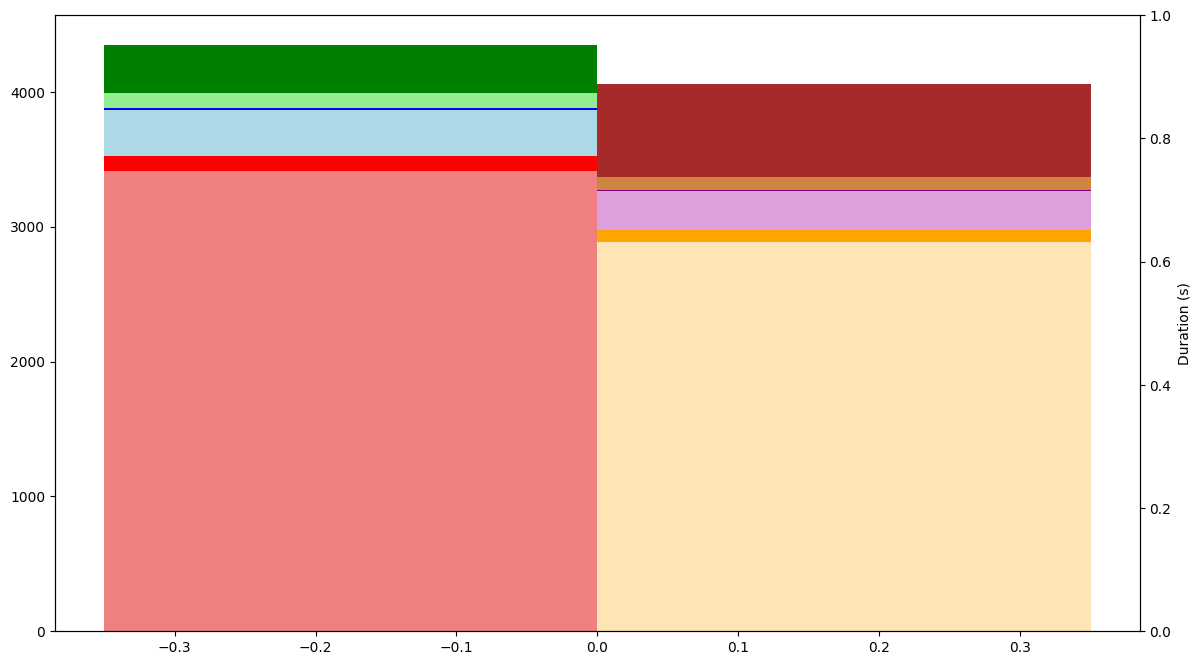

In [17]:
plot_energy_duration(final_df, ['b32W1','b64W1', ])

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
import os

def plot_energy_duration(df, names):
    """
    Plots energy consumption and duration for specified names.

    Parameters:
    - df (pd.DataFrame): DataFrame containing energy and duration data.
    - names (list): List of names to filter and plot.

    The function filters the DataFrame for the specified names and creates a plot with:
    - Two stacked bar plots per name (DL and FBP) on the primary y-axis.
    - Points representing durations on the secondary y-axis.
    """
    # Initialize final_results
    final_results = {}

    # Filter the DataFrame for the specified names
    filtered_df = df[df['name'].isin(names)].copy()

    if filtered_df.empty:
        print("No matching names found in the DataFrame.")
        return

    # Check for duplicate names
    if filtered_df['name'].duplicated().any():
        print("Duplicate names found in the DataFrame. Aggregating data.")
        # Aggregate by summing the energy and durations
        grouped_df = filtered_df.groupby('name').sum().reset_index()
    else:
        grouped_df = filtered_df.reset_index(drop=True)

    # Ensure that grouped_df has the same order as 'names'
    grouped_df['name'] = pd.Categorical(grouped_df['name'], categories=names, ordered=True)
    grouped_df.sort_values('name', inplace=True)

    # Define x positions
    x = np.arange(len(grouped_df))
    width = 0.35  # the width of the bars

    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Create a second y-axis for durations
    ax2 = ax1.twinx()
    ax2.set_ylabel('Duration (s)')
    # ax2.set_ylim(bottom=0) 
    ax2.set_yscale('log',base=2)
    # Define colors
    DL_colors = {'cpu': 'red', 'memory': 'blue', 'gpu': 'green'}
    DL_light_colors = {'cpu': 'lightcoral', 'memory': 'lightblue', 'gpu': 'lightgreen'}

    FBP_colors = {'cpu': 'red', 'memory': 'blue', 'gpu': 'green'}
    FBP_light_colors = {'cpu': 'lightcoral', 'memory': 'lightblue', 'gpu': 'lightgreen'}

    # Plot DL stacked bars
    # CPU
    ax1.bar(x - width/2, grouped_df['DL_cpu_base'], width, color=DL_light_colors['cpu'], label='DL_cpu_base')
    ax1.bar(x - width/2, grouped_df['DL_cpu'] - grouped_df['DL_cpu_base'], width, color=DL_colors['cpu'], bottom=grouped_df['DL_cpu_base'], label='DL_cpu')

    # Memory
    ax1.bar(x - width/2, grouped_df['DL_memory_base'], width, color=DL_light_colors['memory'], bottom=grouped_df['DL_cpu'], label='DL_memory_base')
    ax1.bar(x - width/2, grouped_df['DL_memory'] - grouped_df['DL_memory_base'], width, color=DL_colors['memory'], bottom=grouped_df['DL_cpu'] + grouped_df['DL_memory_base'], label='DL_memory')

    # GPU
    ax1.bar(x - width/2, grouped_df['DL_gpu_base'], width, color=DL_light_colors['gpu'], bottom=grouped_df['DL_cpu'] + grouped_df['DL_memory'], label='DL_gpu_base')
    ax1.bar(x - width/2, grouped_df['DL_gpu'] - grouped_df['DL_gpu_base'], width, color=DL_colors['gpu'], bottom=grouped_df['DL_cpu'] + grouped_df['DL_memory'] + grouped_df['DL_gpu_base'], label='DL_gpu')

    # Plot FBP stacked bars
    # CPU
    ax1.bar(x +0.01+width/2, grouped_df['FBP_cpu_base'], width, color=FBP_light_colors['cpu'], label='FBP_cpu_base')
    ax1.bar(x +0.01+width/2, grouped_df['FBP_cpu'] - grouped_df['FBP_cpu_base'], width, color=FBP_colors['cpu'], bottom=grouped_df['FBP_cpu_base'], label='FBP_cpu')

    # Memory
    ax1.bar(x +0.01+ width/2, grouped_df['FBP_memory_base'], width, color=FBP_light_colors['memory'], bottom=grouped_df['FBP_cpu'], label='FBP_memory_base')
    ax1.bar(x +0.01+ width/2, grouped_df['FBP_memory'] - grouped_df['FBP_memory_base'], width, color=FBP_colors['memory'], bottom=grouped_df['FBP_cpu'] + grouped_df['FBP_memory_base'], label='FBP_memory')

    # GPU
    ax1.bar(x +0.01+ width/2, grouped_df['FBP_gpu_base'], width, color=FBP_light_colors['gpu'], bottom=grouped_df['FBP_cpu'] + grouped_df['FBP_memory'], label='FBP_gpu_base')
    ax1.bar(x +0.01+ width/2, grouped_df['FBP_gpu'] - grouped_df['FBP_gpu_base'], width, color=FBP_colors['gpu'], bottom=grouped_df['FBP_cpu'] + grouped_df['FBP_memory'] + grouped_df['FBP_gpu_base'], label='FBP_gpu')

    # Plot durations as points
    ax2.scatter(x - width/2, grouped_df['DL_duration'], color='black', marker='o', label='DL Duration')
    ax2.scatter(x + width/2, grouped_df['FBP_duration'], color='black', marker='x', label='FBP Duration')

    # Customize x-axis
    ax1.set_xticks(x)
    ax1.set_xticklabels(grouped_df['name'], rotation=45, ha='right')
    ax1.set_xlabel('Name')
    ax1.set_ylabel('Energy Consumption (Joules)')

    # Add legends
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    # Remove duplicates
    by_label1 = dict(zip(labels1, handles1))
    by_label2 = dict(zip(labels2, handles2))
    ax1.legend(by_label1.values(), by_label1.keys(), loc='upper left', bbox_to_anchor=(1, 1))
    ax2.legend(by_label2.values(), by_label2.keys(), loc='upper left', bbox_to_anchor=(1, 0.15))

    # Add grid for better readability
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Set plot title
    plt.title('Energy Consumption and Duration for Different Configurations')
    # Calculate and print statistics
    print("\nStatistical Summary:")
    for i, row in grouped_df.iterrows():
        # Total duration
        total_duration = row['DL_duration'] + row['FBP_duration']
        if total_duration > 0:
            dl_duration_pct = (row['DL_duration'] / total_duration) * 100
        else:
            dl_duration_pct = 0
        
        # Total energy (DL + FBP)
        total_energy = (row['DL_cpu'] + row['DL_memory'] + row['DL_gpu']) + (row['FBP_cpu'] + row['FBP_memory'] + row['FBP_gpu'])
        if total_energy > 0:
            dl_energy = row['DL_cpu'] + row['DL_memory'] + row['DL_gpu']
            dl_energy_pct = (dl_energy / total_energy) * 100
        else:
            dl_energy_pct = 0
        
        # Print statistics
        print(f"\nName: {row['name']}")
        print(f"  Data Loading took {dl_duration_pct:.1f}% time between Data Loading + FBP")
        print(f"  Data Loading consumed {dl_energy_pct:.1f}% of total energy consumption of Data Loading + FBP")
    
    # Adjust y-axis limits to accommodate annotations (optional)
    max_energy = grouped_df[['DL_cpu', 'DL_memory', 'DL_gpu', 'FBP_cpu', 'FBP_memory', 'FBP_gpu']].sum(axis=1).max()
    # ax1.set_ylim(top=max_energy * 1.1)  # 10% more space at the top
    
    # Adjust layout to prevent clipping of tick-labels and legends
    plt.tight_layout()
    
    # Show the plot
    plt.show()





Statistical Summary:

Name: b32W0
  Data Loading took 69.9% time between Data Loading + FBP
  Data Loading consumed 65.6% of total energy consumption of Data Loading + FBP

Name: b32W1
  Data Loading took 54.2% time between Data Loading + FBP
  Data Loading consumed 51.7% of total energy consumption of Data Loading + FBP

Name: b32W8
  Data Loading took 50.9% time between Data Loading + FBP
  Data Loading consumed 48.2% of total energy consumption of Data Loading + FBP

Name: b64W0
  Data Loading took 60.1% time between Data Loading + FBP
  Data Loading consumed 56.2% of total energy consumption of Data Loading + FBP

Name: b64W1
  Data Loading took 64.4% time between Data Loading + FBP
  Data Loading consumed 61.0% of total energy consumption of Data Loading + FBP

Name: b64W8
  Data Loading took 55.7% time between Data Loading + FBP
  Data Loading consumed 52.3% of total energy consumption of Data Loading + FBP

Name: b128W0
  Data Loading took 57.3% time between Data Loading + FBP


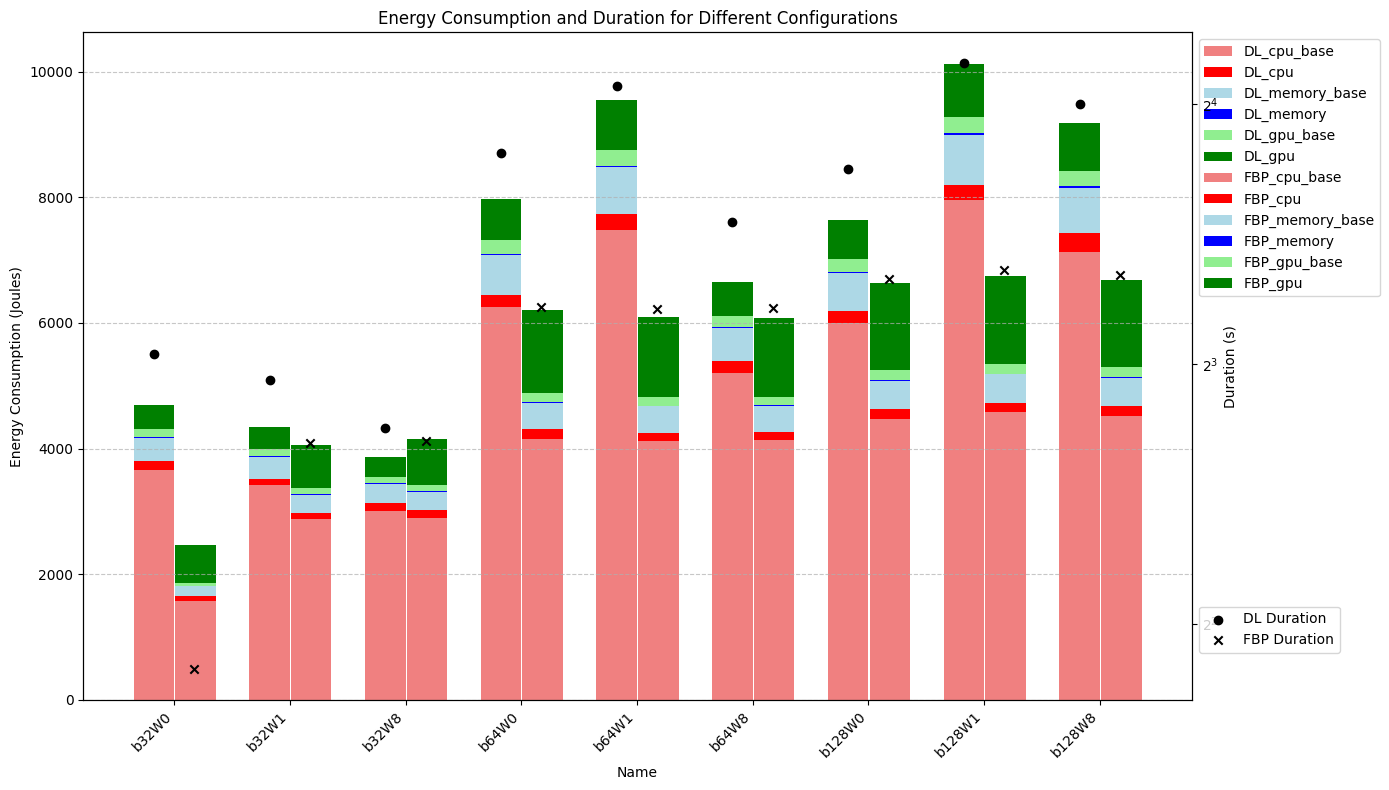

In [54]:
plot_energy_duration(final_df, ['b32W0','b32W1','b32W8','b64W0','b64W1','b64W8','b128W0','b128W1','b128W8' ])


Statistical Summary:

Name: b32W1
  Data Loading took 54.2% time between Data Loading + FBP
  Data Loading consumed 51.7% of total energy consumption of Data Loading + FBP

Name: b32W8
  Data Loading took 50.9% time between Data Loading + FBP
  Data Loading consumed 48.2% of total energy consumption of Data Loading + FBP

Name: b64W1
  Data Loading took 64.4% time between Data Loading + FBP
  Data Loading consumed 61.0% of total energy consumption of Data Loading + FBP

Name: b64W8
  Data Loading took 55.7% time between Data Loading + FBP
  Data Loading consumed 52.3% of total energy consumption of Data Loading + FBP

Name: b128W1
  Data Loading took 63.5% time between Data Loading + FBP
  Data Loading consumed 60.0% of total energy consumption of Data Loading + FBP

Name: b128W8
  Data Loading took 61.2% time between Data Loading + FBP
  Data Loading consumed 57.9% of total energy consumption of Data Loading + FBP


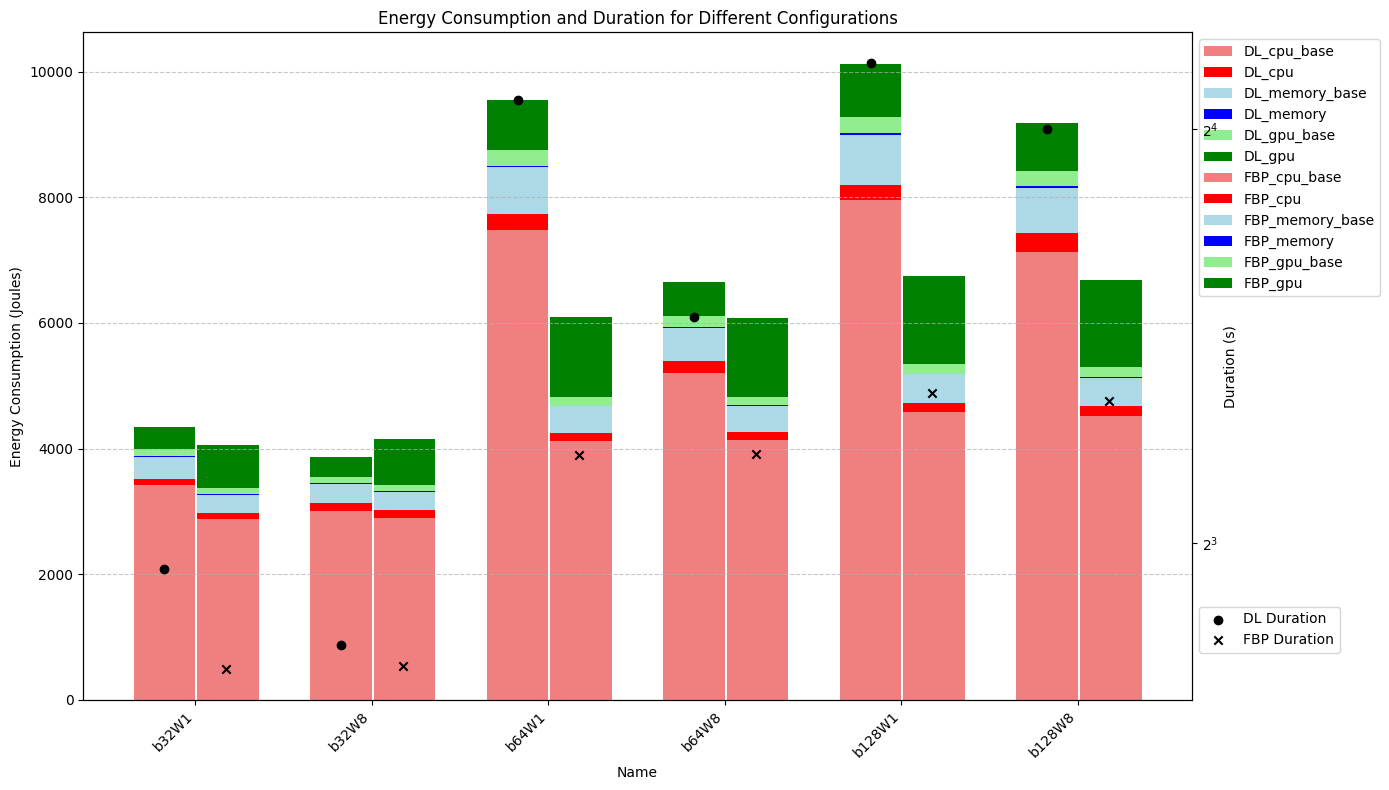

In [55]:
plot_energy_duration(final_df, ['b32W1','b32W8','b64W1','b64W8','b128W1','b128W8' ])

In [56]:
final_df['DL_cpu_task']=final_df['DL_cpu']-final_df['DL_cpu_base']
final_df['DL_memory_task']=final_df['DL_memory']-final_df['DL_memory_base']
final_df['DL_gpu_task']=final_df['DL_gpu']-final_df['DL_gpu_base']

# final_df['FBP_cpu']=final_df["storage1_FBP_cpu"]+final_df["storage2_FBP_cpu"]+final_df["storage3_FBP_cpu"]+final_df["compute2_FBP_cpu"]
# final_df['FBP_cpu_base']=final_df["storage1_FBP_cpu_base"]+final_df["storage2_FBP_cpu_base"]+final_df["storage3_FBP_cpu_base"]+final_df["compute2_FBP_cpu_base"]
# final_df['FBP_memory']=final_df["storage1_FBP_memory"]+final_df["storage2_FBP_memory"]+final_df["storage3_FBP_memory"]+final_df["compute2_FBP_memory"]
# final_df['FBP_memory_base']=final_df["storage1_FBP_memory_base"]+final_df["storage2_FBP_memory_base"]+final_df["storage3_FBP_memory_base"]+final_df["compute2_FBP_memory_base"]
# final_df['FBP_gpu']=final_df["storage1_FBP_gpu"]+final_df["storage2_FBP_gpu"]+final_df["storage3_FBP_gpu"]+final_df["compute2_FBP_gpu"]
# final_df['FBP_gpu_base']=final_df["storage1_FBP_gpu_base"]+final_df["storage2_FBP_gpu_base"]+final_df["storage3_FBP_gpu_base"]+final_df["compute2_FBP_gpu_base"]

final_df['FBP_cpu_task'] = final_df["compute2_FBP_cpu"] - final_df["compute2_FBP_cpu_base"]
final_df['FBP_memory_task'] = final_df["compute2_FBP_memory"] - final_df["compute2_FBP_memory_base"]
final_df['FBP_gpu_task'] = final_df["compute2_FBP_gpu"] - final_df["compute2_FBP_gpu_base"]
 

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
import os


# final_df['DL_cpu_task']=final_df['DL_cpu']-final_df['DL_cpu_base']
# final_df['DL_memory_task']=final_df['DL_memory']-final_df['DL_memory_base']
# final_df['DL_gpu_task']=final_df['DL_gpu']-final_df['DL_gpu_base']

# final_df['FBP_cpu_task'] = final_df["compute2_FBP_cpu"] - final_df["compute2_FBP_cpu_base"]
# final_df['FBP_memory_task'] = final_df["compute2_FBP_memory"] - final_df["compute2_FBP_memory_base"]
# final_df['FBP_gpu_task'] = final_df["compute2_FBP_gpu"] - final_df["compute2_FBP_gpu_base"]

def plot_energy_duration_task(df, names):
    """
    Plots energy consumption and duration for specified names.

    Parameters:
    - df (pd.DataFrame): DataFrame containing energy and duration data.
    - names (list): List of names to filter and plot.

    The function filters the DataFrame for the specified names and creates a plot with:
    - Two stacked bar plots per name (DL and FBP) on the primary y-axis.
    - Points representing durations on the secondary y-axis.
    """
    # Initialize final_results
    final_results = {}

    # Filter the DataFrame for the specified names
    filtered_df = df[df['name'].isin(names)].copy()

    if filtered_df.empty:
        print("No matching names found in the DataFrame.")
        return

    # Check for duplicate names
    if filtered_df['name'].duplicated().any():
        print("Duplicate names found in the DataFrame. Aggregating data.")
        # Aggregate by summing the energy and durations
        grouped_df = filtered_df.groupby('name').sum().reset_index()
    else:
        grouped_df = filtered_df.reset_index(drop=True)

    # Ensure that grouped_df has the same order as 'names'
    grouped_df['name'] = pd.Categorical(grouped_df['name'], categories=names, ordered=True)
    grouped_df.sort_values('name', inplace=True)

    # Define x positions
    x = np.arange(len(grouped_df))
    width = 0.35  # the width of the bars

    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Create a second y-axis for durations
    ax2 = ax1.twinx()
    ax2.set_ylabel('Duration (s)')
    # ax2.set_ylim(bottom=0) 
    ax2.set_yscale('log',base=2)
    # Define colors
    DL_colors = {'cpu': 'red', 'memory': 'blue', 'gpu': 'green'}
    DL_light_colors = {'cpu': 'lightcoral', 'memory': 'lightblue', 'gpu': 'lightgreen'}

    FBP_colors = {'cpu': 'red', 'memory': 'blue', 'gpu': 'green'}
    FBP_light_colors = {'cpu': 'lightcoral', 'memory': 'lightblue', 'gpu': 'lightgreen'}

    # Plot DL stacked bars
    # CPU
    ax1.bar(x - width/2, grouped_df['DL_cpu_task'], width, color=DL_light_colors['cpu'], label='DL_cpu')
    # ax1.bar(x - width/2, grouped_df['DL_cpu'] - grouped_df['DL_cpu_base'], width, color=DL_colors['cpu'], bottom=grouped_df['DL_cpu_base'], label='DL_cpu')

    # Memory
    ax1.bar(x - width/2, grouped_df['DL_memory_task'], width, color=DL_light_colors['memory'], bottom=grouped_df['DL_cpu_task'], label='DL_memory')
    # ax1.bar(x - width/2, grouped_df['DL_memory'] - grouped_df['DL_memory_base'], width, color=DL_colors['memory'], bottom=grouped_df['DL_cpu'] + grouped_df['DL_memory_base'], label='DL_memory')

    # GPU
    ax1.bar(x - width/2, grouped_df['DL_gpu_task'], width, color=DL_light_colors['gpu'], bottom=grouped_df['DL_cpu_task'] + grouped_df['DL_memory_task'], label='DL_gpu')
    # ax1.bar(x - width/2, grouped_df['DL_gpu'] - grouped_df['DL_gpu_base'], width, color=DL_colors['gpu'], bottom=grouped_df['DL_cpu'] + grouped_df['DL_memory'] + grouped_df['DL_gpu_base'], label='DL_gpu')

    # Plot FBP stacked bars
    # CPU
    ax1.bar(x +0.01+width/2, grouped_df['FBP_cpu_task'], width, color=FBP_light_colors['cpu'], label='FBP_cpu')
    # ax1.bar(x +0.01+width/2, grouped_df['FBP_cpu'] - grouped_df['FBP_cpu_base'], width, color=FBP_colors['cpu'], bottom=grouped_df['FBP_cpu_base'], label='FBP_cpu')

    # Memory
    ax1.bar(x +0.01+ width/2, grouped_df['FBP_memory_task'], width, color=FBP_light_colors['memory'], bottom=grouped_df['FBP_cpu_task'], label='FBP_memory')
    # ax1.bar(x +0.01+ width/2, grouped_df['FBP_memory'] - grouped_df['FBP_memory_base'], width, color=FBP_colors['memory'], bottom=grouped_df['FBP_cpu'] + grouped_df['FBP_memory_base'], label='FBP_memory')

    # GPU
    ax1.bar(x +0.01+ width/2, grouped_df['FBP_gpu_task'], width, color=FBP_light_colors['gpu'], bottom=grouped_df['FBP_cpu_task'] + grouped_df['FBP_memory_task'], label='FBP_gpu')
    # ax1.bar(x +0.01+ width/2, grouped_df['FBP_gpu'] - grouped_df['FBP_gpu_base'], width, color=FBP_colors['gpu'], bottom=grouped_df['FBP_cpu'] + grouped_df['FBP_memory'] + grouped_df['FBP_gpu_base'], label='FBP_gpu')

    # Plot durations as points
    ax2.scatter(x - width/2, grouped_df['DL_duration'], color='black', marker='o', label='DL Duration')
    ax2.scatter(x + width/2, grouped_df['FBP_duration'], color='black', marker='x', label='FBP Duration')

    # Customize x-axis
    ax1.set_xticks(x)
    ax1.set_xticklabels(grouped_df['name'], rotation=45, ha='right')
    ax1.set_xlabel('Name')
    ax1.set_ylabel('Energy Consumption (Joules)for tasks only')

    # Add legends
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    # Remove duplicates
    by_label1 = dict(zip(labels1, handles1))
    by_label2 = dict(zip(labels2, handles2))
    ax1.legend(by_label1.values(), by_label1.keys(), loc='upper left', bbox_to_anchor=(1.05, 1))
    ax2.legend(by_label2.values(), by_label2.keys(), loc='upper left', bbox_to_anchor=(1, 0.15))

    # Add grid for better readability
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Set plot title
    plt.title('Energy Consumption and Duration for Different Configurations')
    # Calculate and print statistics
    print("\nStatistical Summary:")
    for i, row in grouped_df.iterrows():
        # Total duration
        total_duration = row['DL_duration'] + row['FBP_duration']
        if total_duration > 0:
            dl_duration_pct = (row['DL_duration'] / total_duration) * 100
        else:
            dl_duration_pct = 0
        
        # Total energy (DL + FBP)
        total_energy = (row['DL_cpu_task'] + row['DL_memory_task'] + row['DL_gpu_task']) + (row['FBP_cpu_task'] + row['FBP_memory_task'] + row['FBP_gpu_task'])
        if total_energy > 0:
            dl_energy = row['DL_cpu_task'] + row['DL_memory_task'] + row['DL_gpu_task']
            dl_energy_pct = (dl_energy / total_energy) * 100
        else:
            dl_energy_pct = 0
        
        # Print statistics
        print(f"\nName: {row['name']}")
        print(f"  Data Loading took {dl_duration_pct:.1f}% time between Data Loading + FBP")
        print(f"  Data Loading consumed {dl_energy_pct:.1f}% of total energy consumption of Data Loading + FBP without idle energy")
    
    # Adjust y-axis limits to accommodate annotations (optional)
    # max_energy = grouped_df[['DL_cpu', 'DL_memory', 'DL_gpu', 'FBP_cpu', 'FBP_memory', 'FBP_gpu']].sum(axis=1).max()
    # ax1.set_ylim(top=max_energy * 1.1)  # 10% more space at the top
    
    # Adjust layout to prevent clipping of tick-labels and legends
    plt.tight_layout()
    
    # Show the plot
    plt.show()





Statistical Summary:

Name: b32W1
  Data Loading took 54.2% time between Data Loading + FBP
  Data Loading consumed 39.7% of total energy consumption of Data Loading + FBP without idle energy

Name: b32W8
  Data Loading took 50.9% time between Data Loading + FBP
  Data Loading consumed 37.4% of total energy consumption of Data Loading + FBP without idle energy

Name: b64W1
  Data Loading took 64.4% time between Data Loading + FBP
  Data Loading consumed 44.5% of total energy consumption of Data Loading + FBP without idle energy

Name: b64W8
  Data Loading took 55.7% time between Data Loading + FBP
  Data Loading consumed 36.7% of total energy consumption of Data Loading + FBP without idle energy

Name: b128W1
  Data Loading took 63.5% time between Data Loading + FBP
  Data Loading consumed 42.7% of total energy consumption of Data Loading + FBP without idle energy

Name: b128W8
  Data Loading took 61.2% time between Data Loading + FBP
  Data Loading consumed 43.0% of total energy cons

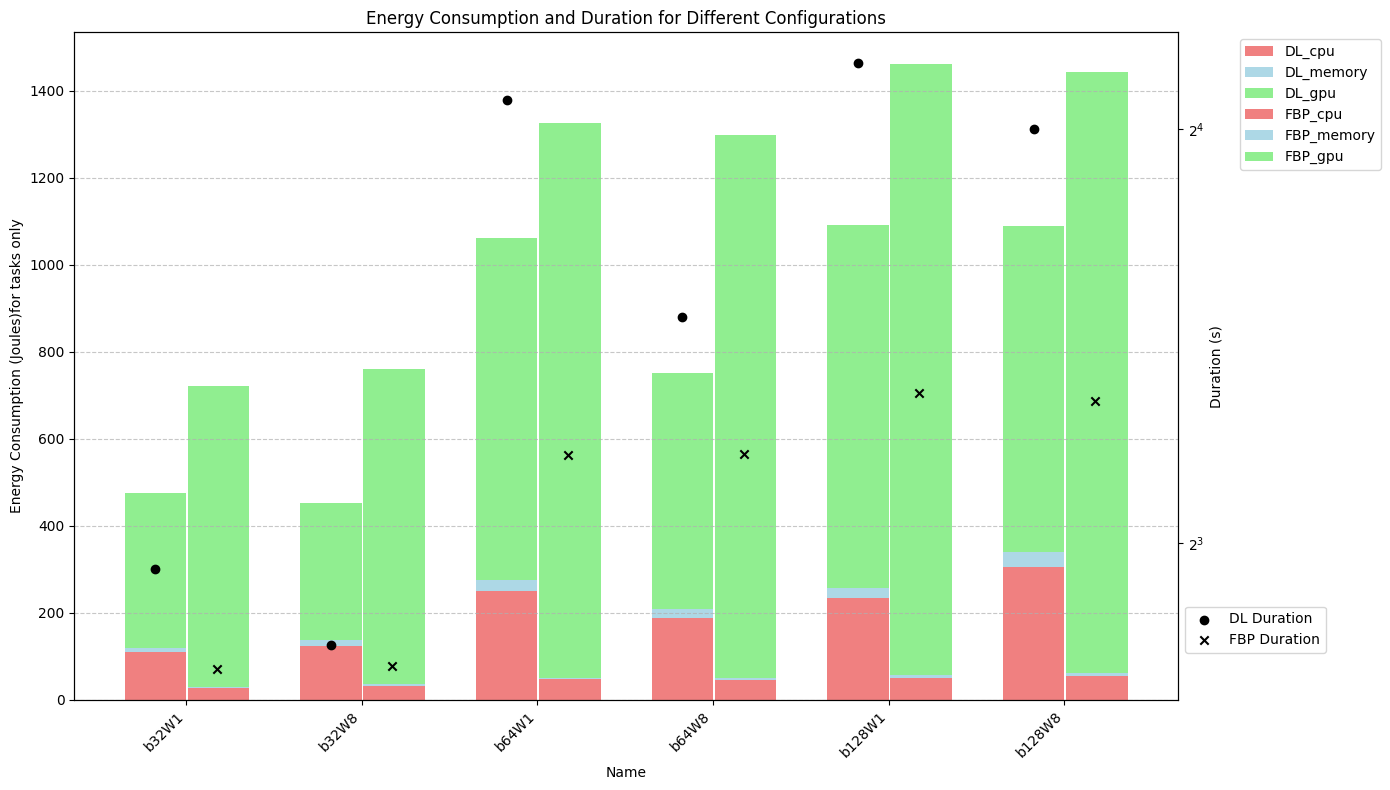

In [58]:
plot_energy_duration_task(final_df, ['b32W1','b32W8','b64W1','b64W8','b128W1','b128W8' ])

In [59]:
list_of_files=["b128_w0_ramdisk.txt",
"b128_w1_ramdisk.txt",
"b128_w8_ramdisk.txt",
"b32_w0_ramdisk.txt",
"b32_w1_ramdisk.txt",
"b32_w8_ramdisk.txt",
"b64_w0_ramdisk.txt",
"b64_w1_ramdisk.txt",
"b64_w8_ramdisk.txt"]

base_directories= "/home/cc/imagenetTrainingWithResnet/results/"
df_list=[]
for file in list_of_files:
    fileName=base_directories+file
    df_list.append(collect_and_process(fileName))


Processing phase 'Data Loading Phase' from 1732761554.2283633 to 1732761559.080583
Expected entries: 49.00

Processing phase 'ForwardBackward Pass phase' from 1732761564.4671605 to 1732761574.6848898
Expected entries: 103.00
     name  DL_duration  storage1_DL_cpu  storage1_DL_cpu_base  \
0  b128W0         4.85       928.612553                907.92   

   storage1_DL_memory  storage1_DL_memory_base  storage1_DL_gpu  \
0           78.243617                    76.63              0.0   

   storage1_DL_gpu_base  FBP_duration  storage1_FBP_cpu  ...  \
0                   0.0         10.22         1950.3565  ...   

   storage2_DL_memory  storage2_DL_memory_base  storage2_DL_gpu  \
0           37.658542                    35.89              0.0   

   storage2_DL_gpu_base  storage2_FBP_cpu  storage2_FBP_cpu_base  \
0                   0.0          935.4769                891.184   

   storage2_FBP_memory  storage2_FBP_memory_base  storage2_FBP_gpu  \
0              79.1349               

In [60]:
final_df_ramdisk = pd.concat(df_list)
final_df_ramdisk.columns

Index(['name', 'DL_duration', 'storage1_DL_cpu', 'storage1_DL_cpu_base',
       'storage1_DL_memory', 'storage1_DL_memory_base', 'storage1_DL_gpu',
       'storage1_DL_gpu_base', 'FBP_duration', 'storage1_FBP_cpu',
       'storage1_FBP_cpu_base', 'storage1_FBP_memory',
       'storage1_FBP_memory_base', 'storage1_FBP_gpu', 'storage1_FBP_gpu_base',
       'compute2_DL_cpu', 'compute2_DL_cpu_base', 'compute2_DL_memory',
       'compute2_DL_memory_base', 'compute2_DL_gpu', 'compute2_DL_gpu_base',
       'compute2_FBP_cpu', 'compute2_FBP_cpu_base', 'compute2_FBP_memory',
       'compute2_FBP_memory_base', 'compute2_FBP_gpu', 'compute2_FBP_gpu_base',
       'storage3_DL_cpu', 'storage3_DL_cpu_base', 'storage3_DL_memory',
       'storage3_DL_memory_base', 'storage3_DL_gpu', 'storage3_DL_gpu_base',
       'storage3_FBP_cpu', 'storage3_FBP_cpu_base', 'storage3_FBP_memory',
       'storage3_FBP_memory_base', 'storage3_FBP_gpu', 'storage3_FBP_gpu_base',
       'storage2_DL_cpu', 'storage2_DL_cpu

In [61]:
final_df_ramdisk['DL_cpu']=final_df_ramdisk["storage1_DL_cpu"]+final_df_ramdisk["storage2_DL_cpu"]+final_df_ramdisk["storage3_DL_cpu"]+final_df_ramdisk["compute2_DL_cpu"]
final_df_ramdisk['DL_cpu_base']=final_df_ramdisk["storage1_DL_cpu_base"]+final_df_ramdisk["storage2_DL_cpu_base"]+final_df_ramdisk["storage3_DL_cpu_base"]+final_df_ramdisk["compute2_DL_cpu_base"]
final_df_ramdisk['DL_memory']=final_df_ramdisk["storage1_DL_memory"]+final_df_ramdisk["storage2_DL_memory"]+final_df_ramdisk["storage3_DL_memory"]+final_df_ramdisk["compute2_DL_memory"]
final_df_ramdisk['DL_memory_base']=final_df_ramdisk["storage1_DL_memory_base"]+final_df_ramdisk["storage2_DL_memory_base"]+final_df_ramdisk["storage3_DL_memory_base"]+final_df_ramdisk["compute2_DL_memory_base"]
final_df_ramdisk['DL_gpu']=final_df_ramdisk["storage1_DL_gpu"]+final_df_ramdisk["storage2_DL_gpu"]+final_df_ramdisk["storage3_DL_gpu"]+final_df_ramdisk["compute2_DL_gpu"]
final_df_ramdisk['DL_gpu_base']=final_df_ramdisk["storage1_DL_gpu_base"]+final_df_ramdisk["storage2_DL_gpu_base"]+final_df_ramdisk["storage3_DL_gpu_base"]+final_df_ramdisk["compute2_DL_gpu_base"]

final_df_ramdisk['FBP_cpu']=final_df_ramdisk["storage1_FBP_cpu"]+final_df_ramdisk["storage2_FBP_cpu"]+final_df_ramdisk["storage3_FBP_cpu"]+final_df_ramdisk["compute2_FBP_cpu"]
final_df_ramdisk['FBP_cpu_base']=final_df_ramdisk["storage1_FBP_cpu_base"]+final_df_ramdisk["storage2_FBP_cpu_base"]+final_df_ramdisk["storage3_FBP_cpu_base"]+final_df_ramdisk["compute2_FBP_cpu_base"]
final_df_ramdisk['FBP_memory']=final_df_ramdisk["storage1_FBP_memory"]+final_df_ramdisk["storage2_FBP_memory"]+final_df_ramdisk["storage3_FBP_memory"]+final_df_ramdisk["compute2_FBP_memory"]
final_df_ramdisk['FBP_memory_base']=final_df_ramdisk["storage1_FBP_memory_base"]+final_df_ramdisk["storage2_FBP_memory_base"]+final_df_ramdisk["storage3_FBP_memory_base"]+final_df_ramdisk["compute2_FBP_memory_base"]
final_df_ramdisk['FBP_gpu']=final_df_ramdisk["storage1_FBP_gpu"]+final_df_ramdisk["storage2_FBP_gpu"]+final_df_ramdisk["storage3_FBP_gpu"]+final_df_ramdisk["compute2_FBP_gpu"]
final_df_ramdisk['FBP_gpu_base']=final_df_ramdisk["storage1_FBP_gpu_base"]+final_df_ramdisk["storage2_FBP_gpu_base"]+final_df_ramdisk["storage3_FBP_gpu_base"]+final_df_ramdisk["compute2_FBP_gpu_base"]


Statistical Summary:

Name: b32W0
  Data Loading took 28.8% time between Data Loading + FBP
  Data Loading consumed 27.0% of total energy consumption of Data Loading + FBP

Name: b32W1
  Data Loading took 31.8% time between Data Loading + FBP
  Data Loading consumed 29.8% of total energy consumption of Data Loading + FBP

Name: b32W8
  Data Loading took 15.2% time between Data Loading + FBP
  Data Loading consumed 14.7% of total energy consumption of Data Loading + FBP

Name: b64W0
  Data Loading took 34.8% time between Data Loading + FBP
  Data Loading consumed 31.9% of total energy consumption of Data Loading + FBP

Name: b64W1
  Data Loading took 36.6% time between Data Loading + FBP
  Data Loading consumed 33.8% of total energy consumption of Data Loading + FBP

Name: b64W8
  Data Loading took 17.4% time between Data Loading + FBP
  Data Loading consumed 16.1% of total energy consumption of Data Loading + FBP

Name: b128W0
  Data Loading took 32.2% time between Data Loading + FBP


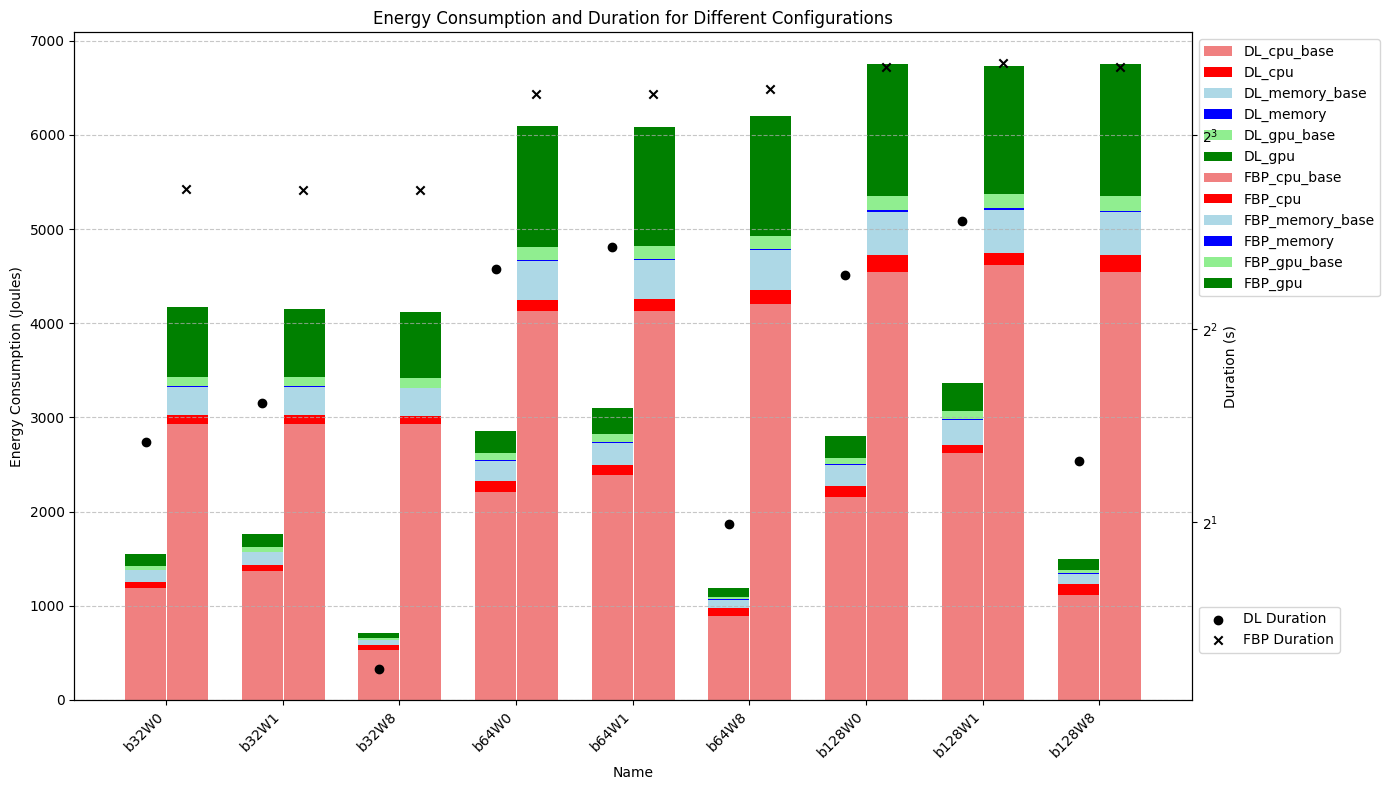

In [62]:
plot_energy_duration(final_df_ramdisk, ['b32W0','b32W1','b32W8','b64W0','b64W1','b64W8','b128W0','b128W1','b128W8' ])

In [63]:
final_df_ramdisk['DL_cpu_task']=final_df_ramdisk['DL_cpu']-final_df_ramdisk['DL_cpu_base']
final_df_ramdisk['DL_memory_task']=final_df_ramdisk['DL_memory']-final_df_ramdisk['DL_memory_base']
final_df_ramdisk['DL_gpu_task']=final_df_ramdisk['DL_gpu']-final_df_ramdisk['DL_gpu_base']

# final_df_ramdisk['FBP_cpu']=final_df_ramdisk["storage1_FBP_cpu"]+final_df_ramdisk["storage2_FBP_cpu"]+final_df_ramdisk["storage3_FBP_cpu"]+final_df_ramdisk["compute2_FBP_cpu"]
# final_df_ramdisk['FBP_cpu_base']=final_df_ramdisk["storage1_FBP_cpu_base"]+final_df_ramdisk["storage2_FBP_cpu_base"]+final_df_ramdisk["storage3_FBP_cpu_base"]+final_df_ramdisk["compute2_FBP_cpu_base"]
# final_df_ramdisk['FBP_memory']=final_df_ramdisk["storage1_FBP_memory"]+final_df_ramdisk["storage2_FBP_memory"]+final_df_ramdisk["storage3_FBP_memory"]+final_df_ramdisk["compute2_FBP_memory"]
# final_df_ramdisk['FBP_memory_base']=final_df_ramdisk["storage1_FBP_memory_base"]+final_df_ramdisk["storage2_FBP_memory_base"]+final_df_ramdisk["storage3_FBP_memory_base"]+final_df_ramdisk["compute2_FBP_memory_base"]
# final_df_ramdisk['FBP_gpu']=final_df_ramdisk["storage1_FBP_gpu"]+final_df_ramdisk["storage2_FBP_gpu"]+final_df_ramdisk["storage3_FBP_gpu"]+final_df_ramdisk["compute2_FBP_gpu"]
# final_df_ramdisk['FBP_gpu_base']=final_df_ramdisk["storage1_FBP_gpu_base"]+final_df_ramdisk["storage2_FBP_gpu_base"]+final_df_ramdisk["storage3_FBP_gpu_base"]+final_df_ramdisk["compute2_FBP_gpu_base"]

final_df_ramdisk['FBP_cpu_task'] = final_df_ramdisk["compute2_FBP_cpu"] - final_df_ramdisk["compute2_FBP_cpu_base"]
final_df_ramdisk['FBP_memory_task'] = final_df_ramdisk["compute2_FBP_memory"] - final_df_ramdisk["compute2_FBP_memory_base"]
final_df_ramdisk['FBP_gpu_task'] = final_df_ramdisk["compute2_FBP_gpu"] - final_df_ramdisk["compute2_FBP_gpu_base"]
 


Statistical Summary:

Name: b32W1
  Data Loading took 31.8% time between Data Loading + FBP
  Data Loading consumed 22.1% of total energy consumption of Data Loading + FBP without idle energy

Name: b32W8
  Data Loading took 15.2% time between Data Loading + FBP
  Data Loading consumed 13.4% of total energy consumption of Data Loading + FBP without idle energy

Name: b64W1
  Data Loading took 36.6% time between Data Loading + FBP
  Data Loading consumed 23.2% of total energy consumption of Data Loading + FBP without idle energy

Name: b64W8
  Data Loading took 17.4% time between Data Loading + FBP
  Data Loading consumed 12.2% of total energy consumption of Data Loading + FBP without idle energy

Name: b128W1
  Data Loading took 36.2% time between Data Loading + FBP
  Data Loading consumed 21.7% of total energy consumption of Data Loading + FBP without idle energy

Name: b128W8
  Data Loading took 19.6% time between Data Loading + FBP
  Data Loading consumed 14.1% of total energy cons

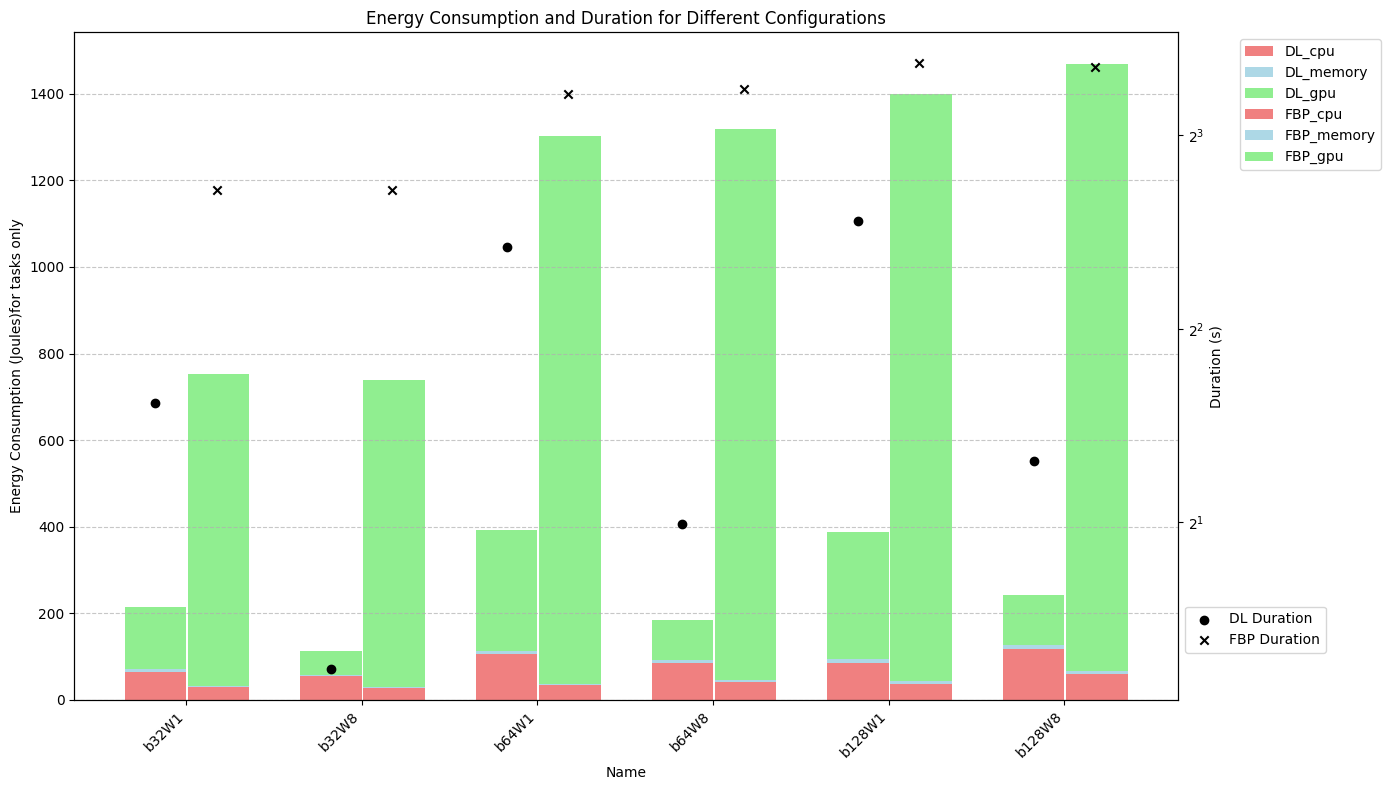

In [64]:
plot_energy_duration_task(final_df_ramdisk, ['b32W1','b32W8','b64W1','b64W8','b128W1','b128W8' ])

In [67]:
final_df_ramdisk

,name,DL_duration,storage1_DL_cpu,storage1_DL_cpu_base,storage1_DL_memory,storage1_DL_memory_base,storage1_DL_gpu,storage1_DL_gpu_base,FBP_duration,storage1_FBP_cpu,...,FBP_memory,FBP_memory_base,FBP_gpu,FBP_gpu_base,DL_cpu_task,DL_memory_task,DL_gpu_task,FBP_cpu_task,FBP_memory_task,FBP_gpu_task
0,b128W0,4.85,928.612553,907.920,78.243617,76.630,0.0,0.0,10.22,1950.356500,...,474.874009,458.878,1550.035556,153.30,115.424107,8.236668,224.878085,62.915293,7.532909,1396.735556
0,b128W1,5.89,1118.497586,1102.608,95.346034,93.062,0.0,0.0,10.38,1971.279216,...,479.869892,466.062,1511.039223,155.70,86.097552,7.578310,294.753276,37.578369,5.680039,1355.339223
0,b128W8,2.49,474.375000,466.128,40.104167,39.342,0.0,0.0,10.22,1951.100909,...,474.401012,458.878,1554.785000,153.30,117.396000,8.603167,115.780000,60.296700,6.891500,1401.485000
0,b32W0,2.67,511.779600,499.824,43.178400,42.186,0.0,0.0,6.59,1255.766769,...,302.593692,295.891,837.650000,98.85,65.282308,4.566231,125.578800,33.002000,2.284000,738.800000
0,b32W1,3.07,587.653103,574.704,49.471724,48.506,0.0,0.0,6.57,1257.392812,...,302.565894,294.993,820.369846,98.55,65.387365,4.940200,143.227143,28.507846,2.798308,721.819846
0,b32W8,1.18,227.705455,220.896,19.265455,18.644,0.0,0.0,6.57,1252.814063,...,303.059106,294.993,806.200000,98.55,54.217455,3.863455,55.800000,27.706000,2.622000,707.650000
0,b64W0,4.96,946.468750,928.512,79.770833,78.368,0.0,0.0,9.28,1763.156000,...,426.016594,416.672,1422.850000,139.20,111.074833,7.535583,233.287500,36.144000,3.348000,1283.650000
0,b64W1,5.36,1023.819231,1003.392,86.046923,84.688,0.0,0.0,9.29,1762.298333,...,425.720737,417.121,1404.219130,139.35,105.057948,7.874433,279.759623,34.857326,2.762261,1264.869130
0,b64W8,1.99,379.410526,372.528,31.936842,31.442,0.0,0.0,9.45,1804.498901,...,435.038246,424.305,1415.265054,141.75,84.583105,6.260579,92.465789,41.919677,3.673226,1273.515054


In [69]:
final_df

,name,DL_duration,storage1_DL_cpu,storage1_DL_cpu_base,storage1_DL_memory,storage1_DL_memory_base,storage1_DL_gpu,storage1_DL_gpu_base,FBP_duration,storage1_FBP_cpu,...,FBP_memory,FBP_memory_base,FBP_gpu,FBP_gpu_base,DL_cpu_task,DL_memory_task,DL_gpu_task,FBP_cpu_task,FBP_memory_task,FBP_gpu_task
0,b128W0,13.48,2559.383588,2523.456,217.040840,212.984,0.0,0.0,10.04,1919.505000,...,467.600019,450.796,1537.199388,150.60,184.979894,17.850179,625.194231,53.586490,6.585735,1386.599388
0,b128W8,16.01,3063.778065,2997.072,259.033419,252.958,0.0,0.0,10.15,1952.125455,...,472.347370,455.735,1533.255758,152.25,305.828994,33.904880,750.489114,55.595455,6.450000,1381.005758
0,b32W1,7.67,1459.191067,1435.824,123.384800,121.186,0.0,0.0,6.48,1232.552344,...,297.750781,290.952,789.516406,97.20,109.293514,10.648195,356.487733,28.048375,2.146906,692.316406
0,b64W0,14.05,2674.893504,2630.160,227.514307,221.990,0.0,0.0,9.32,1788.003956,...,432.082699,418.468,1458.195435,139.80,197.547665,20.064183,659.159137,41.498826,3.595696,1318.395435
0,b64W8,11.68,2223.749211,2186.496,188.195526,184.544,0.0,0.0,9.29,1765.140000,...,426.890551,417.121,1387.812717,139.35,189.095444,20.277875,542.958103,46.654174,2.529761,1248.462717
0,b128W1,17.88,3401.997874,3347.136,288.899828,282.504,0.0,0.0,10.29,1956.367723,...,475.706010,462.021,1559.656900,154.35,233.921629,22.646613,834.501371,49.940900,6.118300,1405.306900
0,b32W0,8.21,1576.887284,1536.912,133.189383,129.718,0.0,0.0,3.54,682.464706,...,165.057277,158.946,646.827429,53.10,151.868454,14.012400,382.996296,22.428000,1.914857,593.727429
0,b32W8,6.75,1292.334769,1263.600,109.103385,106.650,0.0,0.0,6.52,1257.330938,...,302.536339,292.748,821.400938,97.80,124.473583,13.895033,314.669385,32.868188,3.041687,723.600938
0,b64W1,16.80,3212.337485,3144.960,272.152209,265.440,0.0,0.0,9.27,1766.545333,...,427.225826,416.223,1414.236848,139.05,249.052931,25.265191,788.416310,46.962522,2.828087,1275.186848


In [86]:
def get_matching_values(df1, df2, match_col, match_value, target_col):
    """
    Retrieves the values of target_col from both df1 and df2 where match_col equals match_value.

    Parameters:
    - df1 (pd.DataFrame): First DataFrame.
    - df2 (pd.DataFrame): Second DataFrame.
    - match_col (str): Column name to match on.
    - match_value: Value to match in match_col.
    - target_col (str or list): Target column(s) name(s) to retrieve values from.

    Returns:
    - Tuple[pd.DataFrame, pd.DataFrame]: Filtered DataFrames from df1 and df2.
    """
    # Ensure the matching column exists
    for df_name, df in zip(['df1', 'df2'], [df1, df2]):
        if match_col not in df.columns:
            raise ValueError(f"Column '{match_col}' not found in {df_name}.")

    # Convert target_col to a list if it's a string
    if isinstance(target_col, str):
        target_col = [target_col]
    
    # Ensure target columns exist
    for col in target_col:
        for df_name, df in zip(['df1', 'df2'], [df1, df2]):
            if col not in df.columns:
                raise ValueError(f"Column '{col}' not found in {df_name}.")

    # Filter DataFrames
    df1_matches = df1[df1[match_col] == match_value].copy()
    df2_matches = df2[df2[match_col] == match_value].copy()

    return df1_matches[target_col].iloc[0][0], df2_matches[target_col].iloc[0][0]


In [87]:
print(get_matching_values(final_df,final_df_ramdisk,'name','b128W0','DL_gpu_task'))

(np.float64(625.1942307692304), np.float64(224.87808510638297))


/tmp/ipykernel_540256/382835407.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df1_matches[target_col].iloc[0][0], df2_matches[target_col].iloc[0][0]
/tmp/ipykernel_540256/382835407.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df1_matches[target_col].iloc[0][0], df2_matches[target_col].iloc[0][0]


In [88]:
target_config= ['b32W1','b32W8','b64W1','b64W8','b128W1','b128W8' ]
comparison_results={}
for config in target_config:
    string = config+'_duration'
    comparison_results[string]= get_matching_values(final_df,final_df_ramdisk,'name',config,'DL_duration')
    string = config+'_cpuEnergy'
    comparison_results[string]= get_matching_values(final_df,final_df_ramdisk,'name',config,'DL_cpu_task')
    string = config+'_memoryEnergy'
    comparison_results[string]= get_matching_values(final_df,final_df_ramdisk,'name',config,'DL_memory_task')
    string = config+'_gpuEnergy'
    comparison_results[string]= get_matching_values(final_df,final_df_ramdisk,'name',config,'DL_gpu_task')

/tmp/ipykernel_540256/382835407.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df1_matches[target_col].iloc[0][0], df2_matches[target_col].iloc[0][0]
/tmp/ipykernel_540256/382835407.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df1_matches[target_col].iloc[0][0], df2_matches[target_col].iloc[0][0]
/tmp/ipykernel_540256/382835407.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return df1_matches[target

In [89]:
comparison_results

{'b32W1_duration': (np.float64(7.67), np.float64(3.07)),
 'b32W1_cpuEnergy': (np.float64(109.29351403508645),
  np.float64(65.38736535303815)),
 'b32W1_memoryEnergy': (np.float64(10.648194736842129),
  np.float64(4.940200328407201)),
 'b32W1_gpuEnergy': (np.float64(356.4877333333338),
  np.float64(143.2271428571429)),
 'b32W8_duration': (np.float64(6.75), np.float64(1.18)),
 'b32W8_cpuEnergy': (np.float64(124.47358275058332),
  np.float64(54.21745454545464)),
 'b32W8_memoryEnergy': (np.float64(13.895032634032702),
  np.float64(3.8634545454545446)),
 'b32W8_gpuEnergy': (np.float64(314.66938461538484), np.float64(55.8)),
 'b64W1_duration': (np.float64(16.8), np.float64(5.36)),
 'b64W1_cpuEnergy': (np.float64(249.05293084992263),
  np.float64(105.05794775036293)),
 'b64W1_memoryEnergy': (np.float64(25.265191207744124),
  np.float64(7.8744325108853275)),
 'b64W1_gpuEnergy': (np.float64(788.4163095238075),
  np.float64(279.7596226415095)),
 'b64W8_duration': (np.float64(11.68), np.float64(1

In [90]:
import numpy as np

def calculate_percentage_differences(data_dict):
    """
    Takes a dictionary with keys in the format 'identifier_metric' and values as tuples of two numbers.
    Calculates and prints the percentage difference between the two numbers for each metric per identifier.
    
    Parameters:
    - data_dict (dict): Dictionary with keys as 'identifier_metric' and values as tuples of two numbers.
    """
    # Create a dictionary to hold results per identifier
    results = {}
    
    for key, value in data_dict.items():
        # Split the key into identifier and metric
        try:
            identifier, metric = key.split('_', 1)
        except ValueError:
            print(f"Invalid key format: '{key}'. Expected 'identifier_metric'. Skipping.")
            continue
        
        # Ensure the value is a tuple of two numbers
        if not (isinstance(value, tuple) and len(value) == 2):
            print(f"Invalid value for key '{key}'. Expected a tuple of two numbers. Skipping.")
            continue
        
        # Convert numpy.float64 to float if necessary
        val1, val2 = map(float, value)
        
        # Determine larger and smaller values
        larger = max(val1, val2)
        smaller = min(val1, val2)
        
        # Calculate percentage difference
        if larger != 0:
            percentage_diff = ((larger - smaller) / larger) * 100
        else:
            percentage_diff = 0  # Avoid division by zero
        
        # Store the result
        if identifier not in results:
            results[identifier] = {}
        results[identifier][metric] = percentage_diff
    
    # Print the results
    for identifier, metrics in results.items():
        print(f"\nIdentifier: {identifier}")
        for metric, percentage in metrics.items():
            print(f"  {metric}: {percentage:.2f}% difference between values")


In [91]:
calculate_percentage_differences(comparison_results)


Identifier: b32W1
  duration: 59.97% difference between values
  cpuEnergy: 40.17% difference between values
  memoryEnergy: 53.61% difference between values
  gpuEnergy: 59.82% difference between values

Identifier: b32W8
  duration: 82.52% difference between values
  cpuEnergy: 56.44% difference between values
  memoryEnergy: 72.20% difference between values
  gpuEnergy: 82.27% difference between values

Identifier: b64W1
  duration: 68.10% difference between values
  cpuEnergy: 57.82% difference between values
  memoryEnergy: 68.83% difference between values
  gpuEnergy: 64.52% difference between values

Identifier: b64W8
  duration: 82.96% difference between values
  cpuEnergy: 55.27% difference between values
  memoryEnergy: 69.13% difference between values
  gpuEnergy: 82.97% difference between values

Identifier: b128W1
  duration: 67.06% difference between values
  cpuEnergy: 63.19% difference between values
  memoryEnergy: 66.54% difference between values
  gpuEnergy: 64.68% 

In [92]:
import numpy as np

def compare_values_in_terms_of_times(data_dict):
    """
    Takes a dictionary with keys in the format 'identifier_metric' and values as tuples of two numbers.
    Calculates and prints how many times better or worse the new value is compared to the old value.
    
    Parameters:
    - data_dict (dict): Dictionary with keys as 'identifier_metric' and values as tuples of two numbers.
    """
    # Iterate over each item in the dictionary
    for key, value in data_dict.items():
        # Split the key into identifier and metric
        try:
            identifier, metric = key.split('_', 1)
        except ValueError:
            print(f"Invalid key format: '{key}'. Expected 'identifier_metric'. Skipping.")
            continue
        
        # Ensure the value is a tuple of two numbers
        if not (isinstance(value, tuple) and len(value) == 2):
            print(f"Invalid value for key '{key}'. Expected a tuple of two numbers. Skipping.")
            continue
        
        # Convert numpy.float64 to float if necessary
        old_value, new_value = map(float, value)
        
        # Handle division by zero
        if new_value == 0:
            print(f"New value for '{key}' is zero, cannot compute ratio. Skipping.")
            continue
        
        # Calculate the ratio
        ratio = old_value / new_value
        
        # Interpret the result
        if ratio > 1:
            # New value is better
            print(f"{identifier} - {metric}: New value is {ratio:.2f}X better than the old value.")
        elif ratio < 1:
            # New value is worse
            inverse_ratio = 1 / ratio
            print(f"{identifier} - {metric}: New value is {inverse_ratio:.2f}X worse than the old value.")
        else:
            # No change
            print(f"{identifier} - {metric}: No change between old and new values.")


In [93]:
compare_values_in_terms_of_times(comparison_results)

b32W1 - duration: New value is 2.50X better than the old value.
b32W1 - cpuEnergy: New value is 1.67X better than the old value.
b32W1 - memoryEnergy: New value is 2.16X better than the old value.
b32W1 - gpuEnergy: New value is 2.49X better than the old value.
b32W8 - duration: New value is 5.72X better than the old value.
b32W8 - cpuEnergy: New value is 2.30X better than the old value.
b32W8 - memoryEnergy: New value is 3.60X better than the old value.
b32W8 - gpuEnergy: New value is 5.64X better than the old value.
b64W1 - duration: New value is 3.13X better than the old value.
b64W1 - cpuEnergy: New value is 2.37X better than the old value.
b64W1 - memoryEnergy: New value is 3.21X better than the old value.
b64W1 - gpuEnergy: New value is 2.82X better than the old value.
b64W8 - duration: New value is 5.87X better than the old value.
b64W8 - cpuEnergy: New value is 2.24X better than the old value.
b64W8 - memoryEnergy: New value is 3.24X better than the old value.
b64W8 - gpuEnergy

/tmp/ipykernel_540256/1372593526.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metric.sort_values('Identifier', inplace=True)


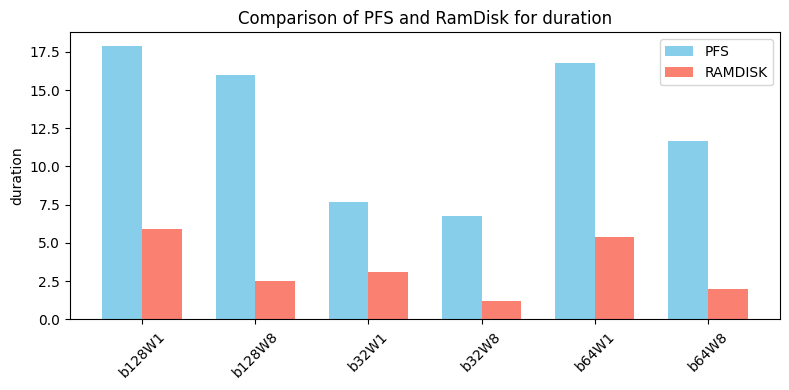

/tmp/ipykernel_540256/1372593526.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metric.sort_values('Identifier', inplace=True)


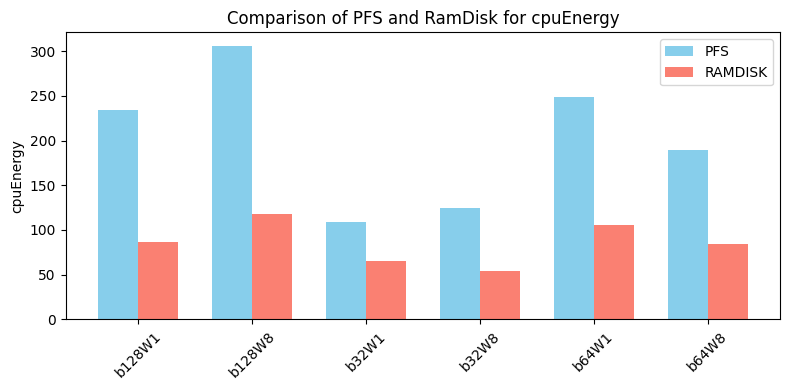

/tmp/ipykernel_540256/1372593526.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metric.sort_values('Identifier', inplace=True)


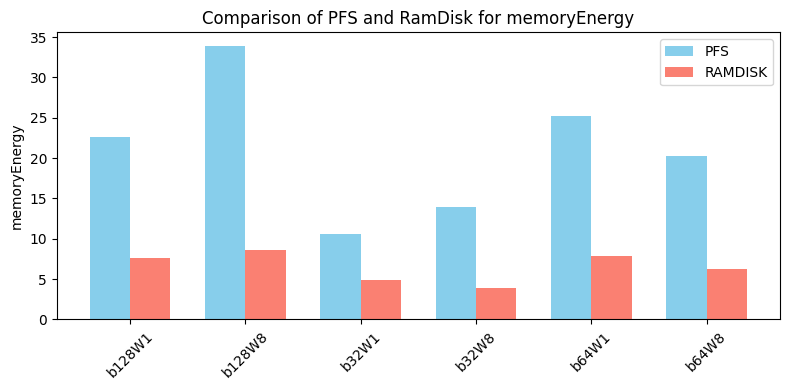

/tmp/ipykernel_540256/1372593526.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metric.sort_values('Identifier', inplace=True)


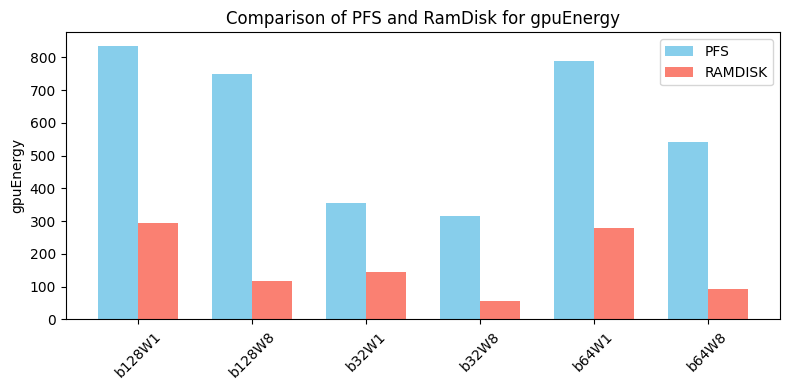

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data preparation (same as before)
comparison_results

# Convert to DataFrame
data_rows = []

for key, value in comparison_results.items():
    try:
        identifier, metric = key.split('_', 1)
    except ValueError:
        print(f"Invalid key format: '{key}'. Expected 'identifier_metric'. Skipping.")
        continue
    
    old_value, new_value = map(float, value)
    ratio = old_value / new_value if new_value != 0 else np.nan
    
    data_rows.append({
        'Identifier': identifier,
        'Metric': metric,
        'Old Value': old_value,
        'New Value': new_value,
        'Ratio': ratio
    })

df = pd.DataFrame(data_rows)

# Plotting function (same as before)
def plot_metrics(df):
    metrics = df['Metric'].unique()
    
    for metric in metrics:
        df_metric = df[df['Metric'] == metric]
        df_metric.sort_values('Identifier', inplace=True)
        
        x = np.arange(len(df_metric))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(8, 4))
        
        rects1 = ax.bar(x - width/2, df_metric['Old Value'], width, label='PFS', color='skyblue')
        rects2 = ax.bar(x + width/2, df_metric['New Value'], width, label='RAMDISK', color='salmon')
        
        ax.set_ylabel(metric)
        ax.set_title(f'Comparison of PFS and RamDisk for {metric}')
        ax.set_xticks(x)
        ax.set_xticklabels(df_metric['Identifier'], rotation=45)
        ax.legend()
        
        # Annotate with ratio
        for i, row in df_metric.iterrows():
            ratio = row['Ratio']
            if pd.notna(ratio):
                ratio_text = f"{ratio:.2f}X"
                if ratio > 1:
                    ratio_text += " better"
                elif ratio < 1:
                    ratio_text += " worse"
                else:
                    ratio_text += " same"
            else:
                ratio_text = "N/A"
            
            # ax.text(i, max(row['Old Value'], row['New Value']) + 0.05 * max(df_metric['Old Value'].max(), df_metric['New Value'].max()), 
            #         ratio_text, ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()

# Call the plotting function
plot_metrics(df)
